In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import re
import mlflow
import shap

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from contextlib import contextmanager

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier

from xgboost import XGBClassifier

from joblib import dump

D:\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
D:\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=1

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

In [2]:
print('Versions des librairies ',
      'pandas : ',pd.__version__,
      ', numpy : ',np.__version__,
      ', seaborn : ',sns.__version__,
      ', mlflow : ',mlflow.__version__)

Versions des librairies  pandas :  2.0.2 , numpy :  1.23.5 , seaborn :  0.12.2 , mlflow :  2.3.2


In [3]:
pd.set_option('Display.max_columns',None)

## Sommaire :

<a href='#1'> 1) EDA
  - <a href='#1a'> app_train
      - <a href='#1a1'> Valeurs manquantes
      - <a href='#1a2'> Valeurs aberrantes
      - <a href='#1a4'> Corrélations
      - <a href='#1a5'> Séparation du jeu d'entraînement
  - <a href='#1b'> app_test
  - <a href='#1c'> bureau
  - <a href='#1d'> bureau_balance
  - <a href='#1e'> credit_card_balance
  - <a href='#1f'> HomeCredit_columns_description
  - <a href='#1g'> installments_payments
  - <a href='#1h'> POS_CASH_balance
  - <a href='#1i'> previous_application
  - <a href='#1j'> sample_submission

<a href='#2'> 2) Feature engineering
    
<a href='#3'> 3) MLTracking
    
<a href='#4'> 4) Modélisation
  - <a href='#4a'> Dummy classifier
  - <a href='#4b'> Regression logistique
  - <a href='#4c'> HistGradientBoostingClassifier
  - <a href='#4d'> KNeighborsClassifier
  - <a href='#4e'> CatBoostClassifier
  - <a href='#4f'> XGBoostClassifier
  - <a href='#4g'> LGBMClassifier
  - <a href='#4h'> Modèle retenu
    
<a href='#5'> 5) Feature importance
    
<a href='#6'> 6) Sauvegardes
    
<a href='#7'> 7) Data drift

# <a name='1'> 1) EDA

## <a name='1a'> app_train

In [4]:
app_train = pd.read_csv('application_train.csv')
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [5]:
app_train.shape

(307511, 122)

Ce fichier comporte 307 511 lignes et 122 colonnes. Chaque ligne est une demande de prêt chez Home Credit identifié par SK_ID_CURR.

La TARGET est à 1 si le client est en difficulté de paiement (il a eu un retard de paiement de plus de X jours sur au moins Y premières échéances du crédit).

Pour chaque prêt, nous connaissons le type de contrat et de nombreuses informations sur le client.

In [6]:
# Type des colonnes
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [7]:
# Nombre de valeurs différentes par colonne catégorielle
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
cibles = app_train['TARGET']
cibles.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

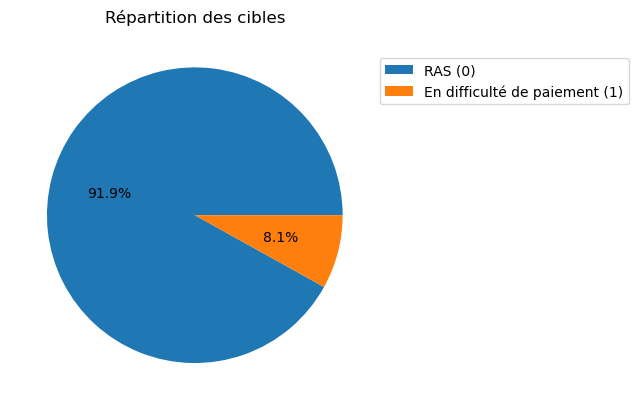

In [9]:
plt.pie(cibles.value_counts(), autopct = '%1.1f%%')
plt.title('Répartition des cibles')
plt.legend(['RAS (0)', 'En difficulté de paiement (1)'], loc = (1,0.8))
plt.show()

Nous voyons que les classes sont déséquilibrées. Il y a beaucoup plus de prêt remboursés à temps.

### <a name='1a1'> Valeurs manquantes

In [10]:
# Fonction qui calcule les valeurs manquantes par colonne

def missing_values_table(df):
        # Total missing values
        mis_val = df.isna().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isna().mean()
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print("Votre dataframe a " + str(df.shape[1]) + " colonnes.\n",      
            str(mis_val_table_ren_columns.shape[0]) +
              " colonnes ont des valeurs manquantes")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Votre dataframe a 122 colonnes.
 67 colonnes ont des valeurs manquantes


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [12]:
# Vérification qu'il n'y a pas de doublons
app_train.duplicated().sum()

0

### <a name='1a2'> Valeurs aberrantes

In [13]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [14]:
(app_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les valeurs sont cohérentes.

In [15]:
(app_train['DAYS_EMPLOYED']/ 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

La plus grande valeur est à 1 000 ans !!!

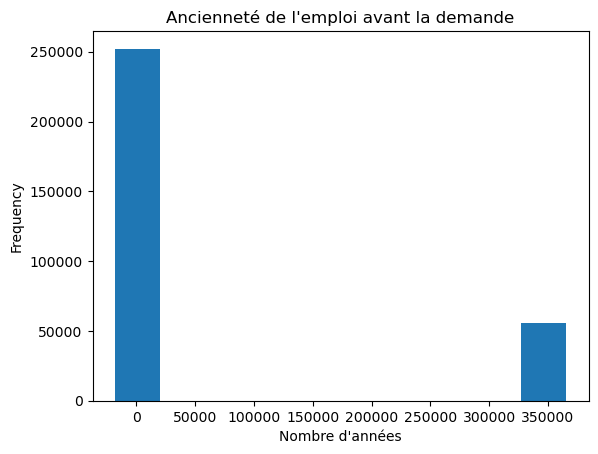

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Ancienneté de l\'emploi avant la demande')
plt.xlabel('Nombre d\'années')
plt.show()

In [17]:
app_train.loc[app_train['DAYS_EMPLOYED'] > 300000, 'DAYS_EMPLOYED'].describe()

count     55374.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: DAYS_EMPLOYED, dtype: float64

55 374 demandes ont une erreur sur 'DAYS_EMPLOYED', toutes égales à 365 243.

In [18]:
app_train['DAYS_EMPLOYED'].isna().sum()

0

Aucune valeur manquante pour cette variable. Nous remplaçons la valeur aberrante 365 243 par np.nan.

In [19]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [20]:
app_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Nous supprimons les 4 lignes qui ont XNA pour CODE_GENDER.

In [21]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

### <a name='1a4'> Corrélations

Quelques interprétations générales de la valeur absolue du coefficient de corrélation :
   - 0-0.19 "très faible"
   - 0.2-0.39 "faible"
   - 0.4-0.59 "modéré"
   - 0.6-0.79 "fort"
   - 0.8-1 "très fort"

In [22]:
var_num = app_train.select_dtypes(['int','float']).columns.to_list()
correlations = app_train[var_num].corr()['TARGET'].sort_values(ascending = False)

In [23]:
# Les 10 plus importantes corrélations positives
correlations.head(10)

TARGET                         1.000000
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050992
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_LIVE_CITY         0.044394
Name: TARGET, dtype: float64

In [24]:
# Les 10 plus importantes corrélations négatives
correlations.tail(10)

ELEVATORS_MEDI               -0.033866
ELEVATORS_AVG                -0.034202
REGION_POPULATION_RELATIVE   -0.037225
AMT_GOODS_PRICE              -0.039647
FLOORSMAX_MODE               -0.043231
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_AVG                -0.044009
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_3                 -0.178926
Name: TARGET, dtype: float64

In [25]:
# # Les 10 plus importantes corrélations
(abs(correlations)).sort_values(ascending = False).head(10)

TARGET                         1.000000
EXT_SOURCE_3                   0.178926
EXT_SOURCE_2                   0.160471
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
Name: TARGET, dtype: float64

Les 3 variables numériques les plus influentes sont des données extérieures. Mettons les de côté.
Ensuite, on a la variable 'DAYS_BIRTH'. Regardons la de plus près.

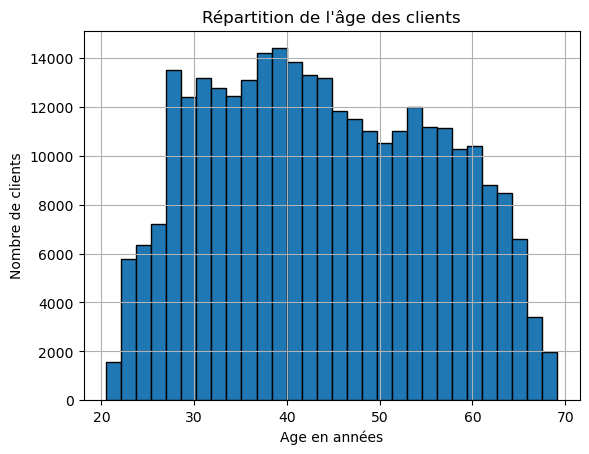

In [26]:
(app_train['DAYS_BIRTH']/-365).hist(bins=30, edgecolor = 'k')
plt.title('Répartition de l\'âge des clients')
plt.xlabel('Age en années')
plt.ylabel('Nombre de clients')
plt.show()

Rien de particulier.

Regroupons par tranche d'âge et regardons le ratio de prêts non remboursés.

In [27]:
df_age = app_train[['TARGET', 'DAYS_BIRTH']]
df_age['YEARS_BIRTH'] = df_age['DAYS_BIRTH']/-365
df_age['Tranche_age'] = pd.cut(df_age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
df_age.head()

TARGET  DAYS_BIRTH  YEARS_BIRTH   Tranche_age
0       1       -9461    25.920548  (25.0, 30.0]
1       0      -16765    45.931507  (45.0, 50.0]
2       0      -19046    52.180822  (50.0, 55.0]
3       0      -19005    52.068493  (50.0, 55.0]
4       0      -19932    54.608219  (50.0, 55.0]

In [28]:
age_groupe = df_age.groupby('Tranche_age').mean()
age_groupe

TARGET    DAYS_BIRTH  YEARS_BIRTH
Tranche_age                                      
(20.0, 25.0]  0.123036  -8532.795625    23.377522
(25.0, 30.0]  0.111442 -10155.219690    27.822520
(30.0, 35.0]  0.102814 -11854.848377    32.479037
(35.0, 40.0]  0.089416 -13707.908041    37.555912
(40.0, 45.0]  0.078491 -15497.661233    42.459346
(45.0, 50.0]  0.074171 -17323.900441    47.462741
(50.0, 55.0]  0.066968 -19196.494791    52.593136
(55.0, 60.0]  0.055316 -20984.285455    57.491193
(60.0, 65.0]  0.052737 -22780.547460    62.412459
(65.0, 70.0]  0.037270 -24292.614340    66.555108

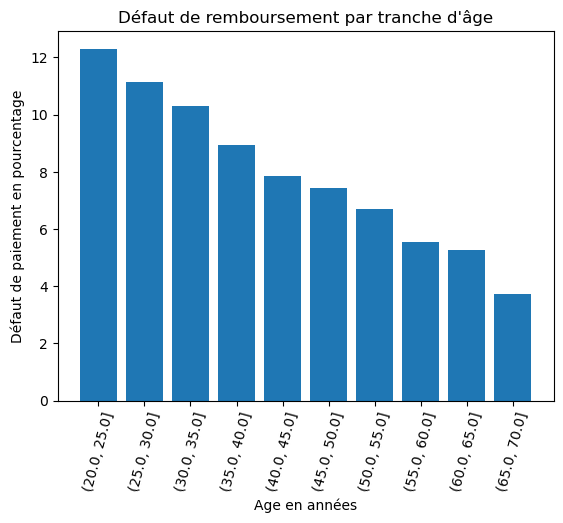

In [29]:
plt.bar(age_groupe.index.astype(str), age_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'âge')
plt.xlabel('Age en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit clairement que plus les clients sont jeunes, plus le défaut de paiement est important.

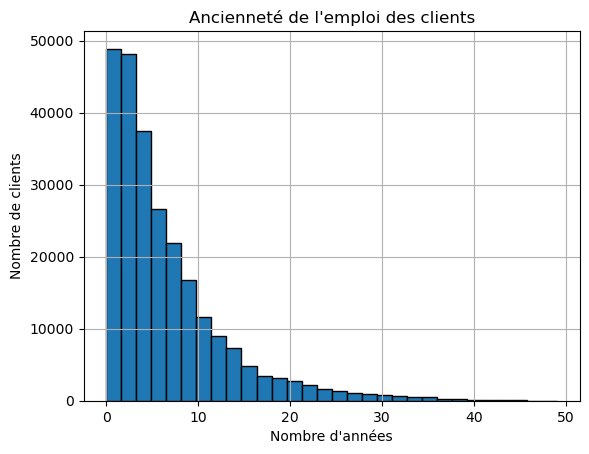

In [30]:
(app_train['DAYS_EMPLOYED']/-365).hist(bins = 30, edgecolor = 'k')
plt.title('Ancienneté de l\'emploi des clients')
plt.xlabel('Nombre d\'années')
plt.ylabel('Nombre de clients')
plt.show()

In [31]:
df_emp = app_train[['TARGET', 'DAYS_EMPLOYED']]
df_emp['YEARS_EMP'] = df_emp['DAYS_EMPLOYED']/-365
df_emp['Tranche_age'] = pd.cut(df_emp['YEARS_EMP'], bins = np.linspace(0, 50, num = 11))
df_emp.head()

TARGET  DAYS_EMPLOYED  YEARS_EMP  Tranche_age
0       1         -637.0   1.745205   (0.0, 5.0]
1       0        -1188.0   3.254795   (0.0, 5.0]
2       0         -225.0   0.616438   (0.0, 5.0]
3       0        -3039.0   8.326027  (5.0, 10.0]
4       0        -3038.0   8.323288  (5.0, 10.0]

In [32]:
emp_groupe = df_emp.groupby('Tranche_age').mean()
emp_groupe

TARGET  DAYS_EMPLOYED  YEARS_EMP
Tranche_age                                     
(0.0, 5.0]    0.105709    -864.338095   2.368050
(5.0, 10.0]   0.073717   -2630.227316   7.206102
(10.0, 15.0]  0.057752   -4466.899670  12.238081
(15.0, 20.0]  0.048484   -6306.860448  17.279070
(20.0, 25.0]  0.047573   -8092.875701  22.172262
(25.0, 30.0]  0.039915   -9961.412156  27.291540
(30.0, 35.0]  0.041258  -11791.751418  32.306168
(35.0, 40.0]  0.019231  -13517.634615  37.034615
(40.0, 45.0]  0.004762  -15325.461905  41.987567
(45.0, 50.0]  0.000000  -16862.916667  46.199772

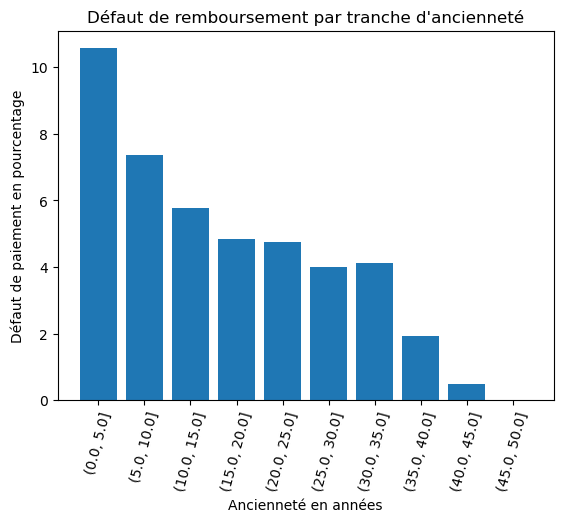

In [33]:
plt.bar(emp_groupe.index.astype(str), emp_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'ancienneté')
plt.xlabel('Ancienneté en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit clairement que plus l'ancienneté est grande, moins le défaut de paiement est important, en cohérence avec l'analyse précédente sur l'âge.

Ensuite, nous avons les variabes 'REGION_RATING_CLIENT' et 'REGION_RATING_CLIENT_W_CITY' qui donnent à un score de localisation : 1, 2 ou 3.

In [34]:
app_train['REGION_RATING_CLIENT'].value_counts()

REGION_RATING_CLIENT
2    226981
3     48329
1     32197
Name: count, dtype: int64

In [35]:
app_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

REGION_RATING_CLIENT_W_CITY
2    229481
3     43859
1     34167
Name: count, dtype: int64

In [36]:
app_train.loc[app_train['REGION_RATING_CLIENT'] != app_train['REGION_RATING_CLIENT_W_CITY'], 'TARGET'].value_counts(normalize = True)

TARGET
0    0.925848
1    0.074152
Name: proportion, dtype: float64

Il n'y a que 5 718 demandes où les 2 scores ne sont pas identiques. La répartition des targets est identique à l'ensemble du dataset (92% de 0).

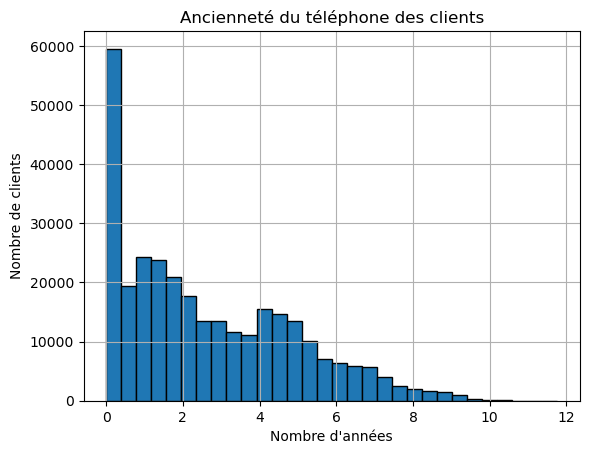

In [37]:
(app_train['DAYS_LAST_PHONE_CHANGE']/-365).hist(bins = 30, edgecolor = 'k')
plt.title('Ancienneté du téléphone des clients')
plt.xlabel('Nombre d\'années')
plt.ylabel('Nombre de clients')
plt.show()

In [38]:
df_emp = app_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']]
df_emp['YEARS_PHONE'] = df_emp['DAYS_LAST_PHONE_CHANGE']/-365
df_emp['Tranche_annee'] = pd.cut(df_emp['YEARS_PHONE'], bins = np.linspace(0, 11, num = 12))
df_emp.head()

TARGET  DAYS_LAST_PHONE_CHANGE  YEARS_PHONE Tranche_annee
0       1                 -1134.0     3.106849    (3.0, 4.0]
1       0                  -828.0     2.268493    (2.0, 3.0]
2       0                  -815.0     2.232877    (2.0, 3.0]
3       0                  -617.0     1.690411    (1.0, 2.0]
4       0                 -1106.0     3.030137    (3.0, 4.0]

In [39]:
phone_groupe = df_emp.groupby('Tranche_annee').mean()
phone_groupe

TARGET  DAYS_LAST_PHONE_CHANGE  YEARS_PHONE
Tranche_annee                                               
(0.0, 1.0]     0.095164             -174.553078     0.478228
(1.0, 2.0]     0.092971             -541.597310     1.483828
(2.0, 3.0]     0.082693             -900.556251     2.467277
(3.0, 4.0]     0.070667            -1272.487454     3.486267
(4.0, 5.0]     0.064304            -1635.270771     4.480194
(5.0, 6.0]     0.060417            -1983.494928     5.434233
(6.0, 7.0]     0.056280            -2368.500922     6.489044
(7.0, 8.0]     0.054142            -2705.349693     7.411917
(8.0, 9.0]     0.045086            -3092.611164     8.472907
(9.0, 10.0]    0.045936            -3405.477032     9.330074
(10.0, 11.0]   0.046632            -3765.668394    10.316900

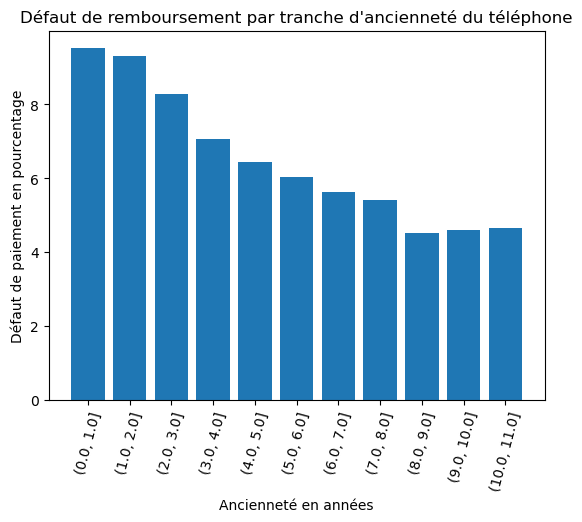

In [40]:
plt.bar(phone_groupe.index.astype(str), phone_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'ancienneté du téléphone')
plt.xlabel('Ancienneté en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit que plus l'ancienneté du téléphone est grande, moins le défaut de paiement est important.

### <a name='1a5'> Séparation du jeu d'entraînement

In [41]:
X_train, X_test, y_train, y_test = train_test_split(app_train.drop('TARGET', axis=1), app_train['TARGET'], test_size=0.2, stratify=app_train['TARGET'], random_state = 0)

In [42]:
y_train.value_counts(normalize = True)

TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

In [43]:
y_test.value_counts(normalize = True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Les proportions sont conservées.

## <a name='1b'> app_test

In [44]:
app_test = pd.read_csv('application_test.csv')
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [45]:
app_test.shape

(48744, 121)

Le fichier test.

## <a name='1c'> bureau

In [46]:
bur = pd.read_csv('bureau.csv')
bur.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [47]:
bur.shape

(1716428, 17)

Ce fichier référence les 1 716 428 demandes de prêts antérieurs que les clients ont obtenu auprès d'autres banques. Chaque ligne représente un crédit.

In [48]:
bur.loc[bur['SK_ID_CURR'] == 215354]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0           215354       5714462        Closed      currency 1         -497   
1           215354       5714463        Active      currency 1         -208   
2           215354       5714464        Active      currency 1         -203   
3           215354       5714465        Active      currency 1         -203   
4           215354       5714466        Active      currency 1         -629   
5           215354       5714467        Active      currency 1         -273   
6           215354       5714468        Active      currency 1          -43   
225157      215354       5714458        Closed      currency 1        -1872   
225158      215354       5714459        Closed      currency 1        -1734   
225159      215354       5714460        Closed      currency 1        -1333   
225160      215354       5714461        Closed      currency 1        -1011   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                        0               -153.0             -153.0   
1                        0               1075.0                NaN   
2                        0                528.0                NaN   
3                        0                  NaN                NaN   
4                        0               1197.0                NaN   
5                        0              27460.0                NaN   
6                        0                 79.0                NaN   
225157                   0               -776.0            -1203.0   
225158                   0               -638.0            -1336.0   
225159                   0              -1089.0             -987.0   
225160                   0               -830.0             -770.0   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                          NaN                   0         91323.0   
1                          NaN                   0        225000.0   
2                          NaN                   0        464323.5   
3                          NaN                   0         90000.0   
4                      77674.5                   0       2700000.0   
5                          0.0                   0        180000.0   
6                          0.0                   0         42103.8   
225157                     NaN                   0        494550.0   
225158                     NaN                   0       1084032.0   
225159                     NaN                   0        102150.0   
225160                     NaN                   0        500463.0   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                      0.00                   NaN                     0.0   
1                 171342.00                   NaN                     0.0   
2                       NaN                   NaN                     0.0   
3                       NaN                   NaN                     0.0   
4                       NaN                   NaN                     0.0   
5                  71017.38             108982.62                     0.0   
6                  42103.80                  0.00                     0.0   
225157                 0.00                  0.00                     0.0   
225158                 0.00                   NaN                     0.0   
225159                  NaN                   NaN                     0.0   
225160                  NaN                   NaN                     0.0   

            CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0       Consumer credit                -131          NaN  
1           Credit card                 -20          NaN  
2       Consumer credit                 -16          NaN  
3           Credit card                 -16          NaN  
4       Consumer credit                 -21          NaN  
5           Credit card                 -31          NaN  
6       Consumer credit                

## <a name='1d'> bureau_balance

In [49]:
bureau_bal = pd.read_csv('bureau_balance.csv')
bureau_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [50]:
bureau_bal.shape

(27299925, 3)

In [51]:
bureau_bal['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [52]:
bureau_bal.loc[bureau_bal['SK_ID_BUREAU'] == 5715448]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0        5715448               0      C
1        5715448              -1      C
2        5715448              -2      C
3        5715448              -3      C
4        5715448              -4      C
5        5715448              -5      C
6        5715448              -6      C
7        5715448              -7      C
8        5715448              -8      C
9        5715448              -9      0
10       5715448             -10      0
11       5715448             -11      X
12       5715448             -12      X
13       5715448             -13      X
14       5715448             -14      0
15       5715448             -15      0
16       5715448             -16      0
17       5715448             -17      0
18       5715448             -18      0
19       5715448             -19      0
20       5715448             -20      X
21       5715448             -21      X
22       5715448             -22      X
23       5715448             -23      X
24       5715448             -24      X
25       5715448             -25      X
26       5715448             -26      X

MONTHS_BALANCE représente le mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)

STATUS :
   - C signifie fermé
   - X signifie état inconnu
   - 0 signifie pas de DPD (days past due -> jours de retard au cours du mois précédent)
   - 1 signifie DPD entre 1-30
   - 2 signifie DPD 31-60
   - 5 signifie DPD 120+ ou vendu ou radié

Ce fichier représente les crédits précédents. Chaque ligne correspond à un mois d'un crédit précédent.

## <a name='1e'> credit_card_balance

In [53]:
cre_card = pd.read_csv('credit_card_balance.csv')
cre_card.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [54]:
cre_card.shape

(3840312, 23)

Ce fichier donne le solde des cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne correspond à un mois du solde d'une carte de crédit et une carte peut avoir plusieurs lignes.

## <a name='1f'> HomeCredit_columns_description

In [55]:
home_credit = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'latin-1')
home_credit.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [56]:
home_credit.shape

(219, 5)

Ce fichier donne les descriptions des variables utilisées dans les autres fichiers

In [57]:
set(sorted(home_credit['Row'].to_list()))

{'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_BALANCE',
 'AMT_CREDIT',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_DOWN_PAYMENT',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_INSTALMENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_TOTAL_RECEIVABLE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CHANNEL_TYPE',
 'CNT_CHILDREN',
 'CNT_CREDIT_PROLONG',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',


## <a name='1g'> installments_payments

In [58]:
ins_pay = pd.read_csv('installments_payments.csv')
ins_pay.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [59]:
ins_pay.shape

(13605401, 8)

Ce fichier donne des informations sur les paiements pour les prêts précédents. Une ligne représente un paiement ou un paiement non effectué.

## <a name='1h'> POS_CASH_balance

In [60]:
pos_ca = pd.read_csv('POS_CASH_balance.csv')
pos_ca.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [61]:
pos_ca.shape

(10001358, 8)

Ce fichier donne des informations sur les crédits précédents par rapport à la demande SK_ID_CURR :
  - MONTHS_BALANCE : mois du solde par rapport à la date de la demande
  - CNT_INSTALMENT : durée du crédit
  - CNT_INSTALMENT_FUTURE : nombre de versements restant à payer

## <a name='1i'> previous_application

In [62]:
prev_app = pd.read_csv('previous_application.csv')
prev_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [63]:
prev_app.shape

(1670214, 37)

Ce fichier donne des informations sur les demandes précédentes de crédit (une ligne par demande) :
   - AMT_ANNUITY : apport
   - AMT_APPLICATION : montant demandé
   - AMT_CREDIT : montant accordé
   - AMT_GOODS_PRICE : coût du bien
   - FLAG_LAST_APPL_PER_CONTRACT : indique s'il s'agit de la dernière demande

## <a name='1j'> sample_submission

In [64]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [65]:
sample_sub.shape

(48744, 2)

Exemple de fichier attendu.

## <a name='2'> Feature engineering

In [66]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes('object').columns.to_list()
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    df = X_train.copy()
    df['TARGET'] = y_train
    test_df = X_test.copy()
    df = pd.concat([df, test_df], ignore_index=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./credit_card_balance.csv', nrows = num_rows)
    cc.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis= 1, inplace = True)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    # General aggregations
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [67]:
num_rows = 10000
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR', rsuffix='_right')

prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR', rsuffix='_right')

pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR', rsuffix='_right')

ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR', rsuffix='_right')

cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR', rsuffix='_right')

X_train = df[df['TARGET'].notnull()]
X_test = df[df['TARGET'].isnull()]

In [68]:
y_train = X_train['TARGET']
X_train = X_train.drop('TARGET', axis=1)
X_test = X_test.drop('TARGET', axis=1)

In [69]:
X_train.shape, y_train.shape

((246005, 738), (246005,))

In [70]:
X_test.shape, y_test.shape

((61502, 738), (61502,))

## <a name='3'> 3) MLTracking

In [71]:
# Enregistrement de la run mlflow
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params = None):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name = run_name):
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
            
        mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("beta_scorer", beta)
        mlflow.set_tag("seuil", seuil_proba)
        mlflow.set_tag("fraction_sample", frac)
                            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [72]:
# Enregistrement des scores sur le train_set
def score_train(model, grid, grid_params, run_name, experiment_name):
    mlflow.set_experiment(experiment_name)
    results = grid.cv_results_
    
    for i in range(len(results['params'])):
        with mlflow.start_run(run_name = run_name + str(i)) as run:  

            mlflow.log_param("folds", grid.cv)

            params = list(grid_params.keys())
            for param in params:
                mlflow.log_param(param, results["param_%s" % param][i])

            for score_name in [score for score in results if "mean_test" in score]:
                mlflow.log_metric(score_name, results[score_name][i])
                mlflow.log_metric(score_name.replace("mean","std"), results[score_name.replace("mean","std")][i])

## <a name='4'> 4) Modélisation

In [73]:
# Création d'un score pour diminuer le nombre de faux négatifs
beta = 3
scorer = make_scorer(fbeta_score, beta = beta)

In [74]:
# Création d'un score métier
def score_metier(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10*fn + fp

In [75]:
# Fonction pour récupérer les scores 
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metier = score_metier(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    beta_score = fbeta_score(y_true, y_pred, beta = beta)
    return {'score_metier': metier, 'accuracy': round(acc, 2), 'beta_score' : beta_score,
            'precision': round(prec, 2), 'recall': round(recall, 2), 'f1_score': round(f_score,2), 'auc': auc}

In [76]:
# création et sauvegarde de la courbe roc
def create_roc_auc_plot(clf, x_data, y_data, run_name):
    name = run_name + '_roc_auc_curve.png'
    RocCurveDisplay.from_estimator(clf, x_data, y_data) 
    plt.savefig(name)
    return name

In [77]:
# création et sauvegarde de la matrice de confusion
def create_confusion_matrix_plot(y_true, y_pred, run_name):
    name = run_name + '_confusion_matrix.png'
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.savefig(name)
    return name

In [78]:
seuil_proba = 0.5
def seuil(estimator, X):
    proba = estimator.predict_proba(X)
    return np.where(proba[:,0] >= seuil_proba, 0, 1)

In [79]:
def create_model(clf, run_name, X, y, params):
    # oversampling
    #oversample = SMOTE()
    #X, y = oversample.fit_resample(X, y)
    
    clf.fit(X, y)
    y_pred = seuil(clf, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(clf, X, y, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    create_experiment('scoring_P7', run_name, run_metrics, model, name_conf_mat, name_curve, params)

In [80]:
def create_model_grid(model, run_name, params, X_sample, y_sample, X_test):
    time_0 = time.time()
    
    # oversampling
    #oversample = SMOTE()
    #X_sample, y_sample = oversample.fit_resample(X_sample, y_sample)
    
    # GridSearch
    grid = RandomizedSearchCV(model, param_distributions = params, scoring = scorer, cv = 5)
    grid.fit(X_sample, y_sample)
    
    # Scores sur le jeu d'entraînement
    grid_params = grid.param_distributions
    score_train(model, grid, grid_params, run_name, 'scoring_P7')
    
    # Scores du meilleur estimateur
    best_params = grid.best_params_
    estimator = grid.best_estimator_
    y_pred = seuil(estimator, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(estimator, X_sample, y_sample, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    
    create_experiment('scoring_P7', run_name, run_metrics, estimator, name_conf_mat, name_curve, best_params)
    
    duration = time.time() - time_0
    print(f'Durée : {duration} s')

### Création d'un échantillon

In [81]:
data = X_train.copy()
data['TARGET'] = y_train

frac = 0.25
sample_data = data.sample(frac=frac)

X_sample = sample_data.drop('TARGET', axis=1)
y_sample = sample_data['TARGET']

In [82]:
X_sample.shape, y_sample.shape

((61501, 738), (61501,))

In [83]:
y_sample.value_counts(normalize=True)

TARGET
0.0    0.919091
1.0    0.080909
Name: proportion, dtype: float64

### Imputation des valeurs manquantes par la médiane

In [84]:
imputer = SimpleImputer(strategy = 'median')
X_sample_imputed = imputer.fit_transform(X_sample)
X_test_imputed = imputer.transform(X_test)

### Class_weight

In [85]:
class_weights = {0:1, 1:10}  # Poids de la classe 0 à 1, Poids de la classe 1 à 10

### <a name='4a'> Dummy Classifier

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Run - DummyClassifier is logged to Experiment - scoring_P7


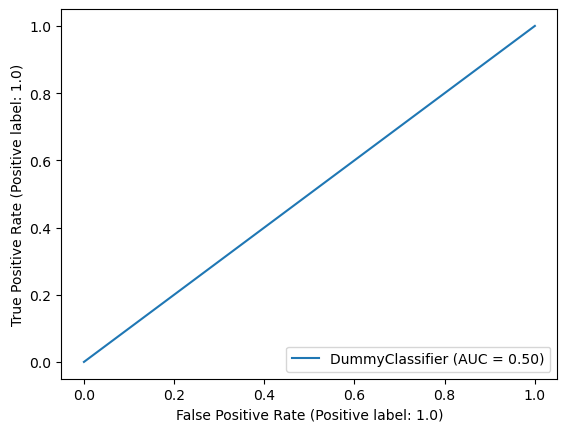

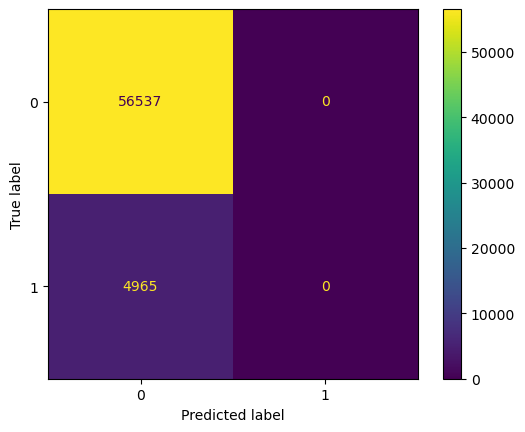

In [98]:
model = DummyClassifier()
create_model(model, 'DummyClassifier', X_sample, y_sample, [])

### <a name='4b'> Regression logistique

penalty : Terme de pénalité utilisé dans la fonction de perte. Vous pouvez choisir entre "l1", "l2", "elasticnet" ou "none". Les pénalités L1 et L2 sont couramment utilisées pour la régularisation.

C : Inverse de la force de régularisation. Une valeur plus petite de C correspond à une régularisation plus forte. Vous pouvez expérimenter avec différentes valeurs de C pour trouver le bon compromis entre l'ajustement du modèle et la régularisation.

solver : Algorithme utilisé pour optimiser les poids. Différents solveurs sont disponibles, tels que "liblinear", "newton-cg", "lbfgs", "sag" et "saga". Le choix du solveur peut affecter la vitesse de convergence et la performance du modèle.

max_iter : Nombre maximum d'itérations pour la convergence de l'optimiseur. Il s'agit du nombre maximum de fois que l'algorithme itérera pour trouver les poids optimaux.

class_weight : Poids associés aux classes d'entraînement. Cela peut être utilisé pour traiter les déséquilibres de classe en attribuant des poids plus élevés aux classes minoritaires

In [ ]:
model = LogisticRegression(class_weight = class_weights)
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 300],
    'class_weight': [None, 'balanced']
}
create_model_grid(model, 'LogisticRegression', params, X_sample_imputed, y_sample, X_test_imputed)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means 

### <a name='4c'> HistGradientBoostingClassifier

learning_rate : Taux d'apprentissage pour les mises à jour des modèles. Il contrôle la contribution de chaque arbre à l'ensemble final. Des valeurs plus petites réduiront la contribution de chaque arbre et nécessiteront généralement plus d'arbres dans l'ensemble.

max_depth : Profondeur maximale de chaque arbre dans l'ensemble. Augmenter la profondeur peut permettre au modèle de capturer des relations plus complexes, mais peut également augmenter le risque de surajustement.

max_iter : Nombre maximum d'itérations (c'est-à-dire le nombre total d'arbres dans l'ensemble) à effectuer lors de l'ajustement du modèle. Cela peut être utile pour contrôler la complexité du modèle et éviter un ajustement excessif.

max_leaf_nodes : Nombre maximum de feuilles dans chaque arbre. Cela peut être utilisé pour contrôler la complexité du modèle en limitant le nombre de feuilles.

min_samples_leaf : Le nombre minimum d'échantillons requis pour former une feuille. Cela peut être utilisé pour contrôler la croissance de l'arbre et éviter le surajustement.

l2_regularization : Terme de régularisation L2 pour contrôler la complexité du modèle et prévenir le surajustement

D:\anaconda3\envs\projet7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning:

Setuptools is replacing distutils.



Run - HistGradientBoosting is logged to Experiment - scoring_P7
Durée : 822.4613540172577 s


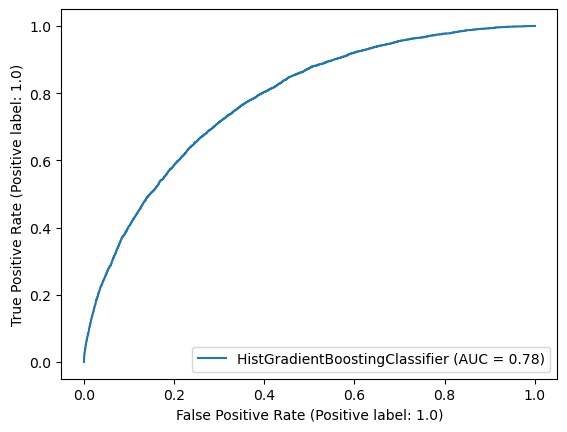

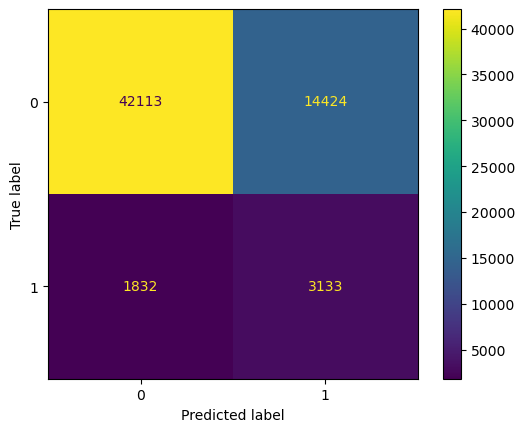

In [89]:
model = HistGradientBoostingClassifier(class_weight = class_weights)
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [None, 10, 100],
    'min_samples_leaf': [1, 5, 10],
    'l2_regularization': [0.0, 0.1, 0.01]
}
create_model_grid(model, 'HistGradientBoosting', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4d'> KNeighbors Classifier

n_neighbors : Il s'agit du nombre de voisins à considérer pour la classification d'un point. Vous pouvez spécifier une liste de valeurs pour tester différentes options.

weights : Ce paramètre détermine la méthode de pondération des voisins. Les valeurs possibles sont 'uniform' (tous les voisins ont le même poids) et 'distance' (les voisins sont pondérés en fonction de leur distance). Vous pouvez également tester différentes options pour ce paramètre.

p : Il s'agit du paramètre de puissance pour la distance de Minkowski. Si p = 1, la distance de Manhattan est utilisée, et si p = 2, la distance euclidienne est utilisée. Vous pouvez tester différentes valeurs pour ce paramètre.

Run - KNeighborsClassifier is logged to Experiment - scoring_P7
Durée : 1748.3205997943878 s


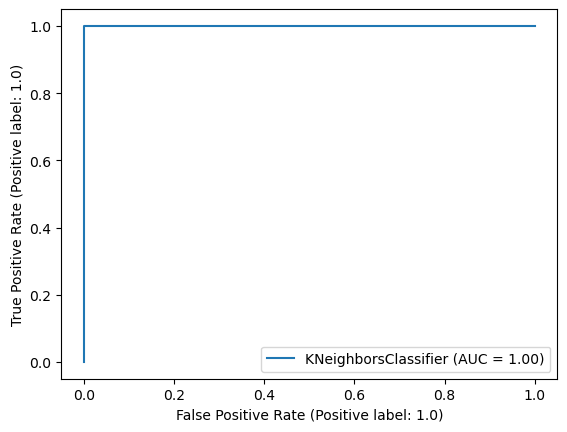

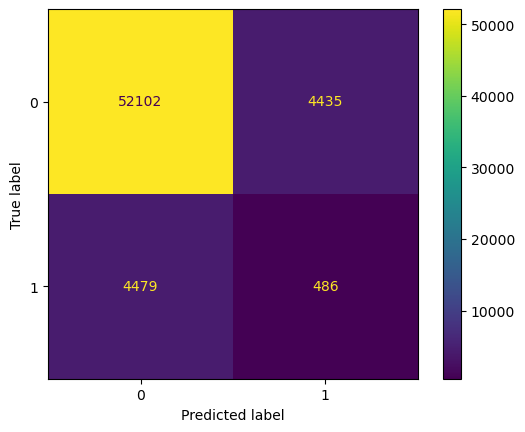

In [90]:
model = KNeighborsClassifier()
params = {
    'n_neighbors': [1,5,9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
create_model_grid(model, 'KNeighborsClassifier', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4e'> CatBoostClassifier

depth: La profondeur maximale de chaque arbre. Une valeur plus élevée peut rendre le modèle plus complexe, mais peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bylevel: La proportion de caractéristiques utilisées pour chaque niveau de chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

l2_leaf_reg: Le terme de régularisation L2 qui pénalise les poids des nœuds de l'arbre. Une valeur plus élevée favorise une réduction plus importante des poids, ce qui peut prévenir le surajustement.

border_count: Le nombre de partitions pour les valeurs continues. Une valeur plus élevée peut améliorer la précision du modèle, mais cela augmente également la complexité et le temps d'entraînement.

random_strength: Le contrôle de la force de la régularisation aléatoire. Une valeur plus élevée peut renforcer la régularisation aléatoire, ce qui peut améliorer la robustesse du modèle.

0:	learn: 0.6916217	total: 224ms	remaining: 22.2s
1:	learn: 0.6901929	total: 245ms	remaining: 12s
2:	learn: 0.6888199	total: 266ms	remaining: 8.59s
3:	learn: 0.6874066	total: 286ms	remaining: 6.86s
4:	learn: 0.6860107	total: 310ms	remaining: 5.89s
5:	learn: 0.6846657	total: 329ms	remaining: 5.16s
6:	learn: 0.6833579	total: 348ms	remaining: 4.62s
7:	learn: 0.6819724	total: 367ms	remaining: 4.22s
8:	learn: 0.6806400	total: 387ms	remaining: 3.92s
9:	learn: 0.6793422	total: 408ms	remaining: 3.67s
10:	learn: 0.6780939	total: 428ms	remaining: 3.46s
11:	learn: 0.6768070	total: 448ms	remaining: 3.29s
12:	learn: 0.6756114	total: 467ms	remaining: 3.13s
13:	learn: 0.6743351	total: 487ms	remaining: 2.99s
14:	learn: 0.6732883	total: 505ms	remaining: 2.86s
15:	learn: 0.6722516	total: 523ms	remaining: 2.75s
16:	learn: 0.6711551	total: 543ms	remaining: 2.65s
17:	learn: 0.6701377	total: 561ms	remaining: 2.56s
18:	learn: 0.6690000	total: 580ms	remaining: 2.47s
19:	learn: 0.6680379	total: 598ms	remaining

70:	learn: 0.6317985	total: 1.31s	remaining: 534ms
71:	learn: 0.6313250	total: 1.33s	remaining: 516ms
72:	learn: 0.6308018	total: 1.35s	remaining: 498ms
73:	learn: 0.6303800	total: 1.36s	remaining: 480ms
74:	learn: 0.6299020	total: 1.38s	remaining: 461ms
75:	learn: 0.6293842	total: 1.4s	remaining: 443ms
76:	learn: 0.6289336	total: 1.42s	remaining: 424ms
77:	learn: 0.6284743	total: 1.44s	remaining: 405ms
78:	learn: 0.6280470	total: 1.45s	remaining: 387ms
79:	learn: 0.6276353	total: 1.47s	remaining: 368ms
80:	learn: 0.6271234	total: 1.49s	remaining: 349ms
81:	learn: 0.6267250	total: 1.51s	remaining: 331ms
82:	learn: 0.6263068	total: 1.53s	remaining: 313ms
83:	learn: 0.6259087	total: 1.54s	remaining: 294ms
84:	learn: 0.6255210	total: 1.56s	remaining: 276ms
85:	learn: 0.6251211	total: 1.58s	remaining: 257ms
86:	learn: 0.6247143	total: 1.6s	remaining: 239ms
87:	learn: 0.6243257	total: 1.62s	remaining: 220ms
88:	learn: 0.6239537	total: 1.64s	remaining: 202ms
89:	learn: 0.6235151	total: 1.65s

38:	learn: 0.6528879	total: 895ms	remaining: 1.4s
39:	learn: 0.6520799	total: 921ms	remaining: 1.38s
40:	learn: 0.6514304	total: 943ms	remaining: 1.36s
41:	learn: 0.6507120	total: 963ms	remaining: 1.33s
42:	learn: 0.6499975	total: 985ms	remaining: 1.31s
43:	learn: 0.6493023	total: 1.01s	remaining: 1.28s
44:	learn: 0.6486575	total: 1.03s	remaining: 1.26s
45:	learn: 0.6480273	total: 1.05s	remaining: 1.23s
46:	learn: 0.6473153	total: 1.07s	remaining: 1.21s
47:	learn: 0.6467104	total: 1.09s	remaining: 1.18s
48:	learn: 0.6460356	total: 1.11s	remaining: 1.16s
49:	learn: 0.6453892	total: 1.13s	remaining: 1.13s
50:	learn: 0.6447744	total: 1.15s	remaining: 1.11s
51:	learn: 0.6441672	total: 1.17s	remaining: 1.08s
52:	learn: 0.6435884	total: 1.2s	remaining: 1.06s
53:	learn: 0.6429727	total: 1.21s	remaining: 1.03s
54:	learn: 0.6423279	total: 1.23s	remaining: 1.01s
55:	learn: 0.6417468	total: 1.25s	remaining: 986ms
56:	learn: 0.6412628	total: 1.27s	remaining: 962ms
57:	learn: 0.6406841	total: 1.29s

0:	learn: 0.6921165	total: 12.7ms	remaining: 2.53s
1:	learn: 0.6908991	total: 24.9ms	remaining: 2.46s
2:	learn: 0.6898889	total: 37ms	remaining: 2.43s
3:	learn: 0.6887700	total: 49ms	remaining: 2.4s
4:	learn: 0.6878832	total: 60.8ms	remaining: 2.37s
5:	learn: 0.6869093	total: 73.3ms	remaining: 2.37s
6:	learn: 0.6857894	total: 85.1ms	remaining: 2.35s
7:	learn: 0.6849189	total: 97.3ms	remaining: 2.33s
8:	learn: 0.6840012	total: 110ms	remaining: 2.33s
9:	learn: 0.6831744	total: 122ms	remaining: 2.31s
10:	learn: 0.6821391	total: 133ms	remaining: 2.29s
11:	learn: 0.6812647	total: 146ms	remaining: 2.28s
12:	learn: 0.6803615	total: 158ms	remaining: 2.27s
13:	learn: 0.6795265	total: 169ms	remaining: 2.25s
14:	learn: 0.6786447	total: 182ms	remaining: 2.24s
15:	learn: 0.6778519	total: 194ms	remaining: 2.23s
16:	learn: 0.6770599	total: 206ms	remaining: 2.22s
17:	learn: 0.6763089	total: 218ms	remaining: 2.21s
18:	learn: 0.6755718	total: 231ms	remaining: 2.2s
19:	learn: 0.6750801	total: 243ms	remai

166:	learn: 0.6235167	total: 2.07s	remaining: 409ms
167:	learn: 0.6234309	total: 2.08s	remaining: 397ms
168:	learn: 0.6233191	total: 2.1s	remaining: 384ms
169:	learn: 0.6231759	total: 2.11s	remaining: 372ms
170:	learn: 0.6230617	total: 2.12s	remaining: 360ms
171:	learn: 0.6229600	total: 2.14s	remaining: 348ms
172:	learn: 0.6228099	total: 2.15s	remaining: 336ms
173:	learn: 0.6226468	total: 2.17s	remaining: 324ms
174:	learn: 0.6225182	total: 2.18s	remaining: 311ms
175:	learn: 0.6224103	total: 2.19s	remaining: 299ms
176:	learn: 0.6222627	total: 2.2s	remaining: 286ms
177:	learn: 0.6221223	total: 2.22s	remaining: 274ms
178:	learn: 0.6219633	total: 2.23s	remaining: 261ms
179:	learn: 0.6218491	total: 2.24s	remaining: 249ms
180:	learn: 0.6216956	total: 2.25s	remaining: 236ms
181:	learn: 0.6215833	total: 2.26s	remaining: 224ms
182:	learn: 0.6214379	total: 2.27s	remaining: 211ms
183:	learn: 0.6213482	total: 2.29s	remaining: 199ms
184:	learn: 0.6212474	total: 2.3s	remaining: 186ms
185:	learn: 0.6

138:	learn: 0.6282836	total: 1.67s	remaining: 732ms
139:	learn: 0.6280966	total: 1.68s	remaining: 720ms
140:	learn: 0.6279601	total: 1.69s	remaining: 709ms
141:	learn: 0.6278293	total: 1.71s	remaining: 696ms
142:	learn: 0.6276431	total: 1.72s	remaining: 684ms
143:	learn: 0.6274069	total: 1.73s	remaining: 672ms
144:	learn: 0.6273126	total: 1.74s	remaining: 660ms
145:	learn: 0.6271527	total: 1.75s	remaining: 648ms
146:	learn: 0.6270172	total: 1.76s	remaining: 636ms
147:	learn: 0.6268083	total: 1.78s	remaining: 624ms
148:	learn: 0.6265970	total: 1.79s	remaining: 612ms
149:	learn: 0.6263953	total: 1.8s	remaining: 600ms
150:	learn: 0.6262863	total: 1.81s	remaining: 589ms
151:	learn: 0.6260980	total: 1.83s	remaining: 577ms
152:	learn: 0.6259125	total: 1.84s	remaining: 565ms
153:	learn: 0.6257901	total: 1.85s	remaining: 553ms
154:	learn: 0.6256317	total: 1.86s	remaining: 541ms
155:	learn: 0.6254312	total: 1.87s	remaining: 529ms
156:	learn: 0.6252726	total: 1.89s	remaining: 517ms
157:	learn: 0

104:	learn: 0.6379469	total: 1.27s	remaining: 1.15s
105:	learn: 0.6376937	total: 1.28s	remaining: 1.14s
106:	learn: 0.6374729	total: 1.29s	remaining: 1.13s
107:	learn: 0.6372400	total: 1.31s	remaining: 1.11s
108:	learn: 0.6369985	total: 1.32s	remaining: 1.1s
109:	learn: 0.6367666	total: 1.33s	remaining: 1.09s
110:	learn: 0.6364974	total: 1.34s	remaining: 1.08s
111:	learn: 0.6363310	total: 1.35s	remaining: 1.06s
112:	learn: 0.6361084	total: 1.37s	remaining: 1.05s
113:	learn: 0.6358617	total: 1.38s	remaining: 1.04s
114:	learn: 0.6356222	total: 1.39s	remaining: 1.03s
115:	learn: 0.6353537	total: 1.41s	remaining: 1.02s
116:	learn: 0.6350678	total: 1.42s	remaining: 1.01s
117:	learn: 0.6348564	total: 1.43s	remaining: 996ms
118:	learn: 0.6346430	total: 1.45s	remaining: 985ms
119:	learn: 0.6343845	total: 1.46s	remaining: 972ms
120:	learn: 0.6341451	total: 1.47s	remaining: 961ms
121:	learn: 0.6338728	total: 1.48s	remaining: 948ms
122:	learn: 0.6336245	total: 1.5s	remaining: 937ms
123:	learn: 0.

70:	learn: 0.6480583	total: 843ms	remaining: 1.53s
71:	learn: 0.6477764	total: 855ms	remaining: 1.52s
72:	learn: 0.6473481	total: 867ms	remaining: 1.51s
73:	learn: 0.6470438	total: 879ms	remaining: 1.5s
74:	learn: 0.6466206	total: 891ms	remaining: 1.49s
75:	learn: 0.6462493	total: 904ms	remaining: 1.48s
76:	learn: 0.6459537	total: 917ms	remaining: 1.46s
77:	learn: 0.6455332	total: 930ms	remaining: 1.45s
78:	learn: 0.6451860	total: 942ms	remaining: 1.44s
79:	learn: 0.6449323	total: 955ms	remaining: 1.43s
80:	learn: 0.6445433	total: 967ms	remaining: 1.42s
81:	learn: 0.6442062	total: 979ms	remaining: 1.41s
82:	learn: 0.6439158	total: 991ms	remaining: 1.4s
83:	learn: 0.6435431	total: 1s	remaining: 1.38s
84:	learn: 0.6431580	total: 1.01s	remaining: 1.37s
85:	learn: 0.6427976	total: 1.03s	remaining: 1.36s
86:	learn: 0.6425403	total: 1.04s	remaining: 1.35s
87:	learn: 0.6421666	total: 1.05s	remaining: 1.34s
88:	learn: 0.6419360	total: 1.06s	remaining: 1.33s
89:	learn: 0.6416149	total: 1.08s	re

34:	learn: 0.6650046	total: 422ms	remaining: 1.99s
35:	learn: 0.6644726	total: 434ms	remaining: 1.97s
36:	learn: 0.6639388	total: 445ms	remaining: 1.96s
37:	learn: 0.6632776	total: 456ms	remaining: 1.95s
38:	learn: 0.6625954	total: 468ms	remaining: 1.93s
39:	learn: 0.6620497	total: 480ms	remaining: 1.92s
40:	learn: 0.6614004	total: 492ms	remaining: 1.91s
41:	learn: 0.6609138	total: 504ms	remaining: 1.9s
42:	learn: 0.6603657	total: 516ms	remaining: 1.88s
43:	learn: 0.6598525	total: 527ms	remaining: 1.87s
44:	learn: 0.6592883	total: 539ms	remaining: 1.86s
45:	learn: 0.6589186	total: 551ms	remaining: 1.84s
46:	learn: 0.6583846	total: 563ms	remaining: 1.83s
47:	learn: 0.6579486	total: 575ms	remaining: 1.82s
48:	learn: 0.6574194	total: 588ms	remaining: 1.81s
49:	learn: 0.6568495	total: 599ms	remaining: 1.8s
50:	learn: 0.6563373	total: 611ms	remaining: 1.78s
51:	learn: 0.6558040	total: 624ms	remaining: 1.77s
52:	learn: 0.6553317	total: 636ms	remaining: 1.76s
53:	learn: 0.6549201	total: 648ms

0:	learn: 0.6907462	total: 36.6ms	remaining: 10.9s
1:	learn: 0.6885500	total: 71.9ms	remaining: 10.7s
2:	learn: 0.6863402	total: 108ms	remaining: 10.6s
3:	learn: 0.6842766	total: 141ms	remaining: 10.4s
4:	learn: 0.6821222	total: 176ms	remaining: 10.4s
5:	learn: 0.6801935	total: 212ms	remaining: 10.4s
6:	learn: 0.6783351	total: 246ms	remaining: 10.3s
7:	learn: 0.6763765	total: 282ms	remaining: 10.3s
8:	learn: 0.6744358	total: 322ms	remaining: 10.4s
9:	learn: 0.6724657	total: 357ms	remaining: 10.4s
10:	learn: 0.6705690	total: 391ms	remaining: 10.3s
11:	learn: 0.6686806	total: 426ms	remaining: 10.2s
12:	learn: 0.6668134	total: 460ms	remaining: 10.1s
13:	learn: 0.6651698	total: 493ms	remaining: 10.1s
14:	learn: 0.6635673	total: 526ms	remaining: 9.99s
15:	learn: 0.6618658	total: 559ms	remaining: 9.93s
16:	learn: 0.6602049	total: 593ms	remaining: 9.87s
17:	learn: 0.6585829	total: 627ms	remaining: 9.82s
18:	learn: 0.6570612	total: 661ms	remaining: 9.77s
19:	learn: 0.6554090	total: 694ms	remai

163:	learn: 0.5501827	total: 5.73s	remaining: 4.75s
164:	learn: 0.5497533	total: 5.77s	remaining: 4.72s
165:	learn: 0.5491347	total: 5.8s	remaining: 4.68s
166:	learn: 0.5487648	total: 5.84s	remaining: 4.65s
167:	learn: 0.5483920	total: 5.87s	remaining: 4.61s
168:	learn: 0.5480248	total: 5.91s	remaining: 4.58s
169:	learn: 0.5476430	total: 5.95s	remaining: 4.55s
170:	learn: 0.5471826	total: 5.98s	remaining: 4.51s
171:	learn: 0.5468063	total: 6.02s	remaining: 4.48s
172:	learn: 0.5463555	total: 6.05s	remaining: 4.44s
173:	learn: 0.5459455	total: 6.09s	remaining: 4.41s
174:	learn: 0.5454567	total: 6.13s	remaining: 4.38s
175:	learn: 0.5450914	total: 6.16s	remaining: 4.34s
176:	learn: 0.5446729	total: 6.2s	remaining: 4.31s
177:	learn: 0.5443281	total: 6.23s	remaining: 4.27s
178:	learn: 0.5439712	total: 6.27s	remaining: 4.24s
179:	learn: 0.5436175	total: 6.3s	remaining: 4.2s
180:	learn: 0.5431709	total: 6.34s	remaining: 4.17s
181:	learn: 0.5428701	total: 6.37s	remaining: 4.13s
182:	learn: 0.54

24:	learn: 0.6484433	total: 858ms	remaining: 9.43s
25:	learn: 0.6469308	total: 893ms	remaining: 9.41s
26:	learn: 0.6455653	total: 928ms	remaining: 9.38s
27:	learn: 0.6441350	total: 963ms	remaining: 9.36s
28:	learn: 0.6427492	total: 998ms	remaining: 9.32s
29:	learn: 0.6413549	total: 1.03s	remaining: 9.29s
30:	learn: 0.6399948	total: 1.07s	remaining: 9.26s
31:	learn: 0.6387237	total: 1.1s	remaining: 9.22s
32:	learn: 0.6374454	total: 1.13s	remaining: 9.18s
33:	learn: 0.6361881	total: 1.17s	remaining: 9.14s
34:	learn: 0.6349995	total: 1.2s	remaining: 9.1s
35:	learn: 0.6338824	total: 1.24s	remaining: 9.06s
36:	learn: 0.6326741	total: 1.27s	remaining: 9.02s
37:	learn: 0.6315139	total: 1.3s	remaining: 8.98s
38:	learn: 0.6304050	total: 1.33s	remaining: 8.94s
39:	learn: 0.6292878	total: 1.37s	remaining: 8.9s
40:	learn: 0.6282300	total: 1.4s	remaining: 8.86s
41:	learn: 0.6272552	total: 1.44s	remaining: 8.82s
42:	learn: 0.6261742	total: 1.47s	remaining: 8.79s
43:	learn: 0.6251132	total: 1.5s	rema

189:	learn: 0.5387986	total: 6.57s	remaining: 3.8s
190:	learn: 0.5382774	total: 6.6s	remaining: 3.77s
191:	learn: 0.5378328	total: 6.64s	remaining: 3.73s
192:	learn: 0.5374013	total: 6.67s	remaining: 3.7s
193:	learn: 0.5370832	total: 6.7s	remaining: 3.66s
194:	learn: 0.5368096	total: 6.73s	remaining: 3.63s
195:	learn: 0.5364169	total: 6.76s	remaining: 3.59s
196:	learn: 0.5360375	total: 6.8s	remaining: 3.55s
197:	learn: 0.5356233	total: 6.83s	remaining: 3.52s
198:	learn: 0.5350393	total: 6.87s	remaining: 3.49s
199:	learn: 0.5347181	total: 6.9s	remaining: 3.45s
200:	learn: 0.5344090	total: 6.93s	remaining: 3.42s
201:	learn: 0.5340234	total: 6.97s	remaining: 3.38s
202:	learn: 0.5337705	total: 7s	remaining: 3.35s
203:	learn: 0.5333665	total: 7.03s	remaining: 3.31s
204:	learn: 0.5330008	total: 7.07s	remaining: 3.27s
205:	learn: 0.5327945	total: 7.1s	remaining: 3.24s
206:	learn: 0.5324412	total: 7.13s	remaining: 3.2s
207:	learn: 0.5320568	total: 7.16s	remaining: 3.17s
208:	learn: 0.5316339	t

50:	learn: 0.6195948	total: 1.74s	remaining: 8.5s
51:	learn: 0.6185597	total: 1.78s	remaining: 8.47s
52:	learn: 0.6176445	total: 1.81s	remaining: 8.44s
53:	learn: 0.6166481	total: 1.84s	remaining: 8.4s
54:	learn: 0.6157917	total: 1.88s	remaining: 8.36s
55:	learn: 0.6149428	total: 1.91s	remaining: 8.32s
56:	learn: 0.6140545	total: 1.95s	remaining: 8.29s
57:	learn: 0.6131092	total: 1.98s	remaining: 8.25s
58:	learn: 0.6121771	total: 2.01s	remaining: 8.23s
59:	learn: 0.6112871	total: 2.05s	remaining: 8.19s
60:	learn: 0.6103994	total: 2.08s	remaining: 8.17s
61:	learn: 0.6095897	total: 2.12s	remaining: 8.15s
62:	learn: 0.6087099	total: 2.16s	remaining: 8.13s
63:	learn: 0.6079185	total: 2.19s	remaining: 8.1s
64:	learn: 0.6070408	total: 2.23s	remaining: 8.07s
65:	learn: 0.6061443	total: 2.27s	remaining: 8.04s
66:	learn: 0.6053599	total: 2.3s	remaining: 8s
67:	learn: 0.6044120	total: 2.34s	remaining: 7.99s
68:	learn: 0.6036975	total: 2.38s	remaining: 7.96s
69:	learn: 0.6029121	total: 2.41s	rema

210:	learn: 0.5346446	total: 7.12s	remaining: 3s
211:	learn: 0.5343141	total: 7.16s	remaining: 2.97s
212:	learn: 0.5339611	total: 7.19s	remaining: 2.94s
213:	learn: 0.5336415	total: 7.22s	remaining: 2.9s
214:	learn: 0.5332413	total: 7.25s	remaining: 2.87s
215:	learn: 0.5329449	total: 7.28s	remaining: 2.83s
216:	learn: 0.5325791	total: 7.32s	remaining: 2.8s
217:	learn: 0.5321936	total: 7.35s	remaining: 2.77s
218:	learn: 0.5319753	total: 7.38s	remaining: 2.73s
219:	learn: 0.5316957	total: 7.41s	remaining: 2.7s
220:	learn: 0.5313503	total: 7.45s	remaining: 2.66s
221:	learn: 0.5310773	total: 7.48s	remaining: 2.63s
222:	learn: 0.5307791	total: 7.51s	remaining: 2.59s
223:	learn: 0.5304083	total: 7.54s	remaining: 2.56s
224:	learn: 0.5301197	total: 7.58s	remaining: 2.52s
225:	learn: 0.5298149	total: 7.61s	remaining: 2.49s
226:	learn: 0.5294611	total: 7.64s	remaining: 2.46s
227:	learn: 0.5291689	total: 7.68s	remaining: 2.42s
228:	learn: 0.5288199	total: 7.71s	remaining: 2.39s
229:	learn: 0.5285

73:	learn: 0.6010754	total: 2.58s	remaining: 7.89s
74:	learn: 0.6003301	total: 2.62s	remaining: 7.85s
75:	learn: 0.5996468	total: 2.65s	remaining: 7.82s
76:	learn: 0.5989051	total: 2.68s	remaining: 7.78s
77:	learn: 0.5981885	total: 2.72s	remaining: 7.74s
78:	learn: 0.5974924	total: 2.75s	remaining: 7.7s
79:	learn: 0.5966817	total: 2.79s	remaining: 7.66s
80:	learn: 0.5960261	total: 2.82s	remaining: 7.62s
81:	learn: 0.5954031	total: 2.85s	remaining: 7.58s
82:	learn: 0.5948111	total: 2.88s	remaining: 7.54s
83:	learn: 0.5941127	total: 2.92s	remaining: 7.5s
84:	learn: 0.5934816	total: 2.95s	remaining: 7.47s
85:	learn: 0.5927437	total: 2.98s	remaining: 7.43s
86:	learn: 0.5920371	total: 3.02s	remaining: 7.39s
87:	learn: 0.5914525	total: 3.05s	remaining: 7.35s
88:	learn: 0.5908414	total: 3.08s	remaining: 7.31s
89:	learn: 0.5902207	total: 3.12s	remaining: 7.27s
90:	learn: 0.5895602	total: 3.15s	remaining: 7.23s
91:	learn: 0.5889936	total: 3.18s	remaining: 7.19s
92:	learn: 0.5884193	total: 3.21s

238:	learn: 0.5246544	total: 8.07s	remaining: 2.06s
239:	learn: 0.5243798	total: 8.1s	remaining: 2.02s
240:	learn: 0.5240761	total: 8.13s	remaining: 1.99s
241:	learn: 0.5238465	total: 8.16s	remaining: 1.96s
242:	learn: 0.5234463	total: 8.2s	remaining: 1.92s
243:	learn: 0.5232331	total: 8.23s	remaining: 1.89s
244:	learn: 0.5228809	total: 8.26s	remaining: 1.85s
245:	learn: 0.5225399	total: 8.3s	remaining: 1.82s
246:	learn: 0.5222579	total: 8.33s	remaining: 1.79s
247:	learn: 0.5220208	total: 8.36s	remaining: 1.75s
248:	learn: 0.5216514	total: 8.39s	remaining: 1.72s
249:	learn: 0.5213145	total: 8.43s	remaining: 1.69s
250:	learn: 0.5209049	total: 8.46s	remaining: 1.65s
251:	learn: 0.5205997	total: 8.5s	remaining: 1.62s
252:	learn: 0.5203025	total: 8.53s	remaining: 1.58s
253:	learn: 0.5200304	total: 8.56s	remaining: 1.55s
254:	learn: 0.5197725	total: 8.59s	remaining: 1.52s
255:	learn: 0.5193936	total: 8.63s	remaining: 1.48s
256:	learn: 0.5190294	total: 8.66s	remaining: 1.45s
257:	learn: 0.51

104:	learn: 0.5802617	total: 3.7s	remaining: 6.87s
105:	learn: 0.5795607	total: 3.74s	remaining: 6.84s
106:	learn: 0.5789806	total: 3.77s	remaining: 6.81s
107:	learn: 0.5784352	total: 3.81s	remaining: 6.77s
108:	learn: 0.5779179	total: 3.86s	remaining: 6.76s
109:	learn: 0.5773761	total: 3.89s	remaining: 6.72s
110:	learn: 0.5769010	total: 3.93s	remaining: 6.68s
111:	learn: 0.5763247	total: 3.96s	remaining: 6.65s
112:	learn: 0.5757961	total: 4s	remaining: 6.61s
113:	learn: 0.5753314	total: 4.03s	remaining: 6.58s
114:	learn: 0.5747557	total: 4.07s	remaining: 6.54s
115:	learn: 0.5742459	total: 4.1s	remaining: 6.51s
116:	learn: 0.5736853	total: 4.14s	remaining: 6.47s
117:	learn: 0.5730356	total: 4.17s	remaining: 6.43s
118:	learn: 0.5725771	total: 4.2s	remaining: 6.39s
119:	learn: 0.5719882	total: 4.24s	remaining: 6.36s
120:	learn: 0.5715730	total: 4.27s	remaining: 6.32s
121:	learn: 0.5711255	total: 4.3s	remaining: 6.28s
122:	learn: 0.5706446	total: 4.34s	remaining: 6.24s
123:	learn: 0.57022

264:	learn: 0.5140433	total: 9.39s	remaining: 1.24s
265:	learn: 0.5137197	total: 9.43s	remaining: 1.21s
266:	learn: 0.5134515	total: 9.46s	remaining: 1.17s
267:	learn: 0.5132444	total: 9.49s	remaining: 1.13s
268:	learn: 0.5130126	total: 9.53s	remaining: 1.1s
269:	learn: 0.5126713	total: 9.56s	remaining: 1.06s
270:	learn: 0.5123682	total: 9.59s	remaining: 1.03s
271:	learn: 0.5120524	total: 9.62s	remaining: 991ms
272:	learn: 0.5117476	total: 9.66s	remaining: 955ms
273:	learn: 0.5114625	total: 9.69s	remaining: 920ms
274:	learn: 0.5111180	total: 9.73s	remaining: 884ms
275:	learn: 0.5108702	total: 9.76s	remaining: 848ms
276:	learn: 0.5106140	total: 9.79s	remaining: 813ms
277:	learn: 0.5104491	total: 9.82s	remaining: 777ms
278:	learn: 0.5101655	total: 9.86s	remaining: 742ms
279:	learn: 0.5099300	total: 9.89s	remaining: 707ms
280:	learn: 0.5096635	total: 9.93s	remaining: 671ms
281:	learn: 0.5093492	total: 9.98s	remaining: 637ms
282:	learn: 0.5090917	total: 10s	remaining: 601ms
283:	learn: 0.5

130:	learn: 0.6119313	total: 3.07s	remaining: 3.96s
131:	learn: 0.6116824	total: 3.09s	remaining: 3.94s
132:	learn: 0.6114102	total: 3.11s	remaining: 3.91s
133:	learn: 0.6111182	total: 3.13s	remaining: 3.88s
134:	learn: 0.6108882	total: 3.16s	remaining: 3.86s
135:	learn: 0.6106200	total: 3.18s	remaining: 3.83s
136:	learn: 0.6103484	total: 3.2s	remaining: 3.81s
137:	learn: 0.6100416	total: 3.22s	remaining: 3.78s
138:	learn: 0.6098249	total: 3.24s	remaining: 3.76s
139:	learn: 0.6096310	total: 3.26s	remaining: 3.73s
140:	learn: 0.6093500	total: 3.29s	remaining: 3.71s
141:	learn: 0.6091424	total: 3.31s	remaining: 3.68s
142:	learn: 0.6089184	total: 3.33s	remaining: 3.65s
143:	learn: 0.6086715	total: 3.35s	remaining: 3.63s
144:	learn: 0.6084467	total: 3.37s	remaining: 3.6s
145:	learn: 0.6082039	total: 3.39s	remaining: 3.58s
146:	learn: 0.6080312	total: 3.41s	remaining: 3.55s
147:	learn: 0.6078068	total: 3.43s	remaining: 3.53s
148:	learn: 0.6075981	total: 3.46s	remaining: 3.5s
149:	learn: 0.6

298:	learn: 0.5855374	total: 6.7s	remaining: 22.4ms
299:	learn: 0.5854496	total: 6.72s	remaining: 0us
0:	learn: 0.6916155	total: 22.7ms	remaining: 6.78s
1:	learn: 0.6902020	total: 43.3ms	remaining: 6.44s
2:	learn: 0.6887621	total: 68.1ms	remaining: 6.74s
3:	learn: 0.6873770	total: 89.3ms	remaining: 6.61s
4:	learn: 0.6861343	total: 113ms	remaining: 6.67s
5:	learn: 0.6849316	total: 134ms	remaining: 6.58s
6:	learn: 0.6837869	total: 162ms	remaining: 6.76s
7:	learn: 0.6824589	total: 184ms	remaining: 6.72s
8:	learn: 0.6810887	total: 207ms	remaining: 6.7s
9:	learn: 0.6798489	total: 228ms	remaining: 6.62s
10:	learn: 0.6786319	total: 254ms	remaining: 6.67s
11:	learn: 0.6774186	total: 276ms	remaining: 6.62s
12:	learn: 0.6762043	total: 300ms	remaining: 6.63s
13:	learn: 0.6750634	total: 324ms	remaining: 6.61s
14:	learn: 0.6738266	total: 348ms	remaining: 6.61s
15:	learn: 0.6727669	total: 369ms	remaining: 6.55s
16:	learn: 0.6716872	total: 397ms	remaining: 6.61s
17:	learn: 0.6706341	total: 417ms	rema

160:	learn: 0.6042569	total: 3.73s	remaining: 3.22s
161:	learn: 0.6040244	total: 3.75s	remaining: 3.19s
162:	learn: 0.6038316	total: 3.77s	remaining: 3.17s
163:	learn: 0.6035902	total: 3.79s	remaining: 3.15s
164:	learn: 0.6033716	total: 3.82s	remaining: 3.12s
165:	learn: 0.6031530	total: 3.84s	remaining: 3.1s
166:	learn: 0.6029775	total: 3.86s	remaining: 3.07s
167:	learn: 0.6027635	total: 3.88s	remaining: 3.05s
168:	learn: 0.6025842	total: 3.9s	remaining: 3.02s
169:	learn: 0.6024165	total: 3.92s	remaining: 3s
170:	learn: 0.6022529	total: 3.94s	remaining: 2.98s
171:	learn: 0.6020871	total: 3.96s	remaining: 2.95s
172:	learn: 0.6018452	total: 3.99s	remaining: 2.93s
173:	learn: 0.6016722	total: 4.01s	remaining: 2.9s
174:	learn: 0.6014779	total: 4.03s	remaining: 2.88s
175:	learn: 0.6012640	total: 4.05s	remaining: 2.85s
176:	learn: 0.6011043	total: 4.08s	remaining: 2.83s
177:	learn: 0.6008853	total: 4.1s	remaining: 2.81s
178:	learn: 0.6007094	total: 4.12s	remaining: 2.79s
179:	learn: 0.60050

28:	learn: 0.6605042	total: 636ms	remaining: 5.94s
29:	learn: 0.6596114	total: 656ms	remaining: 5.9s
30:	learn: 0.6586476	total: 678ms	remaining: 5.89s
31:	learn: 0.6578544	total: 700ms	remaining: 5.86s
32:	learn: 0.6570182	total: 722ms	remaining: 5.84s
33:	learn: 0.6561464	total: 743ms	remaining: 5.81s
34:	learn: 0.6553145	total: 767ms	remaining: 5.81s
35:	learn: 0.6545725	total: 788ms	remaining: 5.78s
36:	learn: 0.6537936	total: 811ms	remaining: 5.76s
37:	learn: 0.6529894	total: 832ms	remaining: 5.73s
38:	learn: 0.6522968	total: 856ms	remaining: 5.72s
39:	learn: 0.6515610	total: 876ms	remaining: 5.7s
40:	learn: 0.6508050	total: 901ms	remaining: 5.69s
41:	learn: 0.6500547	total: 923ms	remaining: 5.67s
42:	learn: 0.6494009	total: 946ms	remaining: 5.65s
43:	learn: 0.6487163	total: 967ms	remaining: 5.62s
44:	learn: 0.6480690	total: 990ms	remaining: 5.61s
45:	learn: 0.6473968	total: 1.01s	remaining: 5.58s
46:	learn: 0.6467523	total: 1.03s	remaining: 5.56s
47:	learn: 0.6460512	total: 1.05s

189:	learn: 0.6005698	total: 4.25s	remaining: 2.46s
190:	learn: 0.6003828	total: 4.28s	remaining: 2.44s
191:	learn: 0.6001918	total: 4.3s	remaining: 2.42s
192:	learn: 0.6000454	total: 4.32s	remaining: 2.4s
193:	learn: 0.5998711	total: 4.35s	remaining: 2.37s
194:	learn: 0.5997473	total: 4.37s	remaining: 2.35s
195:	learn: 0.5995791	total: 4.39s	remaining: 2.33s
196:	learn: 0.5994012	total: 4.42s	remaining: 2.31s
197:	learn: 0.5992497	total: 4.44s	remaining: 2.29s
198:	learn: 0.5991108	total: 4.46s	remaining: 2.26s
199:	learn: 0.5989506	total: 4.49s	remaining: 2.24s
200:	learn: 0.5987743	total: 4.52s	remaining: 2.22s
201:	learn: 0.5986087	total: 4.54s	remaining: 2.2s
202:	learn: 0.5984467	total: 4.56s	remaining: 2.18s
203:	learn: 0.5983063	total: 4.58s	remaining: 2.16s
204:	learn: 0.5981207	total: 4.61s	remaining: 2.13s
205:	learn: 0.5980151	total: 4.63s	remaining: 2.11s
206:	learn: 0.5978000	total: 4.65s	remaining: 2.09s
207:	learn: 0.5976772	total: 4.67s	remaining: 2.06s
208:	learn: 0.5

49:	learn: 0.6457675	total: 1.1s	remaining: 5.49s
50:	learn: 0.6451885	total: 1.12s	remaining: 5.47s
51:	learn: 0.6445505	total: 1.14s	remaining: 5.44s
52:	learn: 0.6439476	total: 1.16s	remaining: 5.42s
53:	learn: 0.6434381	total: 1.18s	remaining: 5.39s
54:	learn: 0.6427972	total: 1.21s	remaining: 5.38s
55:	learn: 0.6421754	total: 1.23s	remaining: 5.35s
56:	learn: 0.6415965	total: 1.25s	remaining: 5.34s
57:	learn: 0.6410555	total: 1.27s	remaining: 5.31s
58:	learn: 0.6405187	total: 1.3s	remaining: 5.29s
59:	learn: 0.6399679	total: 1.32s	remaining: 5.27s
60:	learn: 0.6393823	total: 1.34s	remaining: 5.25s
61:	learn: 0.6389225	total: 1.36s	remaining: 5.22s
62:	learn: 0.6384187	total: 1.38s	remaining: 5.21s
63:	learn: 0.6378321	total: 1.41s	remaining: 5.18s
64:	learn: 0.6373735	total: 1.43s	remaining: 5.17s
65:	learn: 0.6368562	total: 1.45s	remaining: 5.14s
66:	learn: 0.6364017	total: 1.47s	remaining: 5.13s
67:	learn: 0.6358804	total: 1.49s	remaining: 5.1s
68:	learn: 0.6353445	total: 1.52s	

218:	learn: 0.5962750	total: 4.8s	remaining: 1.77s
219:	learn: 0.5961194	total: 4.82s	remaining: 1.75s
220:	learn: 0.5960171	total: 4.84s	remaining: 1.73s
221:	learn: 0.5959063	total: 4.86s	remaining: 1.71s
222:	learn: 0.5957890	total: 4.88s	remaining: 1.69s
223:	learn: 0.5956244	total: 4.91s	remaining: 1.66s
224:	learn: 0.5954677	total: 4.93s	remaining: 1.64s
225:	learn: 0.5953359	total: 4.95s	remaining: 1.62s
226:	learn: 0.5951805	total: 4.97s	remaining: 1.6s
227:	learn: 0.5950483	total: 4.99s	remaining: 1.58s
228:	learn: 0.5949153	total: 5.02s	remaining: 1.55s
229:	learn: 0.5948006	total: 5.04s	remaining: 1.53s
230:	learn: 0.5946056	total: 5.06s	remaining: 1.51s
231:	learn: 0.5945270	total: 5.08s	remaining: 1.49s
232:	learn: 0.5943983	total: 5.1s	remaining: 1.47s
233:	learn: 0.5942684	total: 5.12s	remaining: 1.45s
234:	learn: 0.5941531	total: 5.14s	remaining: 1.42s
235:	learn: 0.5940029	total: 5.17s	remaining: 1.4s
236:	learn: 0.5938821	total: 5.19s	remaining: 1.38s
237:	learn: 0.59

80:	learn: 0.6294948	total: 1.8s	remaining: 4.87s
81:	learn: 0.6291152	total: 1.82s	remaining: 4.84s
82:	learn: 0.6286193	total: 1.84s	remaining: 4.82s
83:	learn: 0.6281967	total: 1.86s	remaining: 4.79s
84:	learn: 0.6277889	total: 1.89s	remaining: 4.78s
85:	learn: 0.6273845	total: 1.91s	remaining: 4.75s
86:	learn: 0.6269208	total: 1.93s	remaining: 4.73s
87:	learn: 0.6265624	total: 1.95s	remaining: 4.71s
88:	learn: 0.6261639	total: 1.98s	remaining: 4.7s
89:	learn: 0.6258025	total: 2s	remaining: 4.67s
90:	learn: 0.6253800	total: 2.02s	remaining: 4.64s
91:	learn: 0.6249924	total: 2.04s	remaining: 4.62s
92:	learn: 0.6245715	total: 2.07s	remaining: 4.61s
93:	learn: 0.6241794	total: 2.09s	remaining: 4.58s
94:	learn: 0.6238047	total: 2.11s	remaining: 4.56s
95:	learn: 0.6234596	total: 2.13s	remaining: 4.53s
96:	learn: 0.6231014	total: 2.16s	remaining: 4.51s
97:	learn: 0.6227408	total: 2.18s	remaining: 4.49s
98:	learn: 0.6223130	total: 2.2s	remaining: 4.47s
99:	learn: 0.6219752	total: 2.22s	rem

240:	learn: 0.5935853	total: 5.29s	remaining: 1.29s
241:	learn: 0.5934952	total: 5.31s	remaining: 1.27s
242:	learn: 0.5933461	total: 5.33s	remaining: 1.25s
243:	learn: 0.5932486	total: 5.36s	remaining: 1.23s
244:	learn: 0.5931191	total: 5.38s	remaining: 1.21s
245:	learn: 0.5930214	total: 5.4s	remaining: 1.19s
246:	learn: 0.5929393	total: 5.42s	remaining: 1.16s
247:	learn: 0.5927752	total: 5.44s	remaining: 1.14s
248:	learn: 0.5926606	total: 5.46s	remaining: 1.12s
249:	learn: 0.5925480	total: 5.49s	remaining: 1.1s
250:	learn: 0.5924066	total: 5.51s	remaining: 1.07s
251:	learn: 0.5922686	total: 5.53s	remaining: 1.05s
252:	learn: 0.5921379	total: 5.55s	remaining: 1.03s
253:	learn: 0.5920584	total: 5.57s	remaining: 1.01s
254:	learn: 0.5919629	total: 5.59s	remaining: 987ms
255:	learn: 0.5918451	total: 5.62s	remaining: 965ms
256:	learn: 0.5917373	total: 5.64s	remaining: 943ms
257:	learn: 0.5916242	total: 5.66s	remaining: 921ms
258:	learn: 0.5915036	total: 5.68s	remaining: 899ms
259:	learn: 0.

108:	learn: 0.6301378	total: 1.51s	remaining: 1.26s
109:	learn: 0.6298940	total: 1.53s	remaining: 1.25s
110:	learn: 0.6296478	total: 1.54s	remaining: 1.23s
111:	learn: 0.6293915	total: 1.55s	remaining: 1.22s
112:	learn: 0.6291592	total: 1.56s	remaining: 1.2s
113:	learn: 0.6289201	total: 1.58s	remaining: 1.19s
114:	learn: 0.6286848	total: 1.59s	remaining: 1.18s
115:	learn: 0.6284401	total: 1.6s	remaining: 1.16s
116:	learn: 0.6282027	total: 1.61s	remaining: 1.15s
117:	learn: 0.6279587	total: 1.63s	remaining: 1.13s
118:	learn: 0.6277312	total: 1.64s	remaining: 1.11s
119:	learn: 0.6274954	total: 1.65s	remaining: 1.1s
120:	learn: 0.6272670	total: 1.66s	remaining: 1.08s
121:	learn: 0.6270409	total: 1.68s	remaining: 1.07s
122:	learn: 0.6268312	total: 1.69s	remaining: 1.06s
123:	learn: 0.6266162	total: 1.7s	remaining: 1.04s
124:	learn: 0.6263973	total: 1.71s	remaining: 1.03s
125:	learn: 0.6261869	total: 1.73s	remaining: 1.01s
126:	learn: 0.6259752	total: 1.74s	remaining: 999ms
127:	learn: 0.62

82:	learn: 0.6380297	total: 1.1s	remaining: 1.55s
83:	learn: 0.6376942	total: 1.11s	remaining: 1.53s
84:	learn: 0.6373444	total: 1.12s	remaining: 1.52s
85:	learn: 0.6370187	total: 1.14s	remaining: 1.51s
86:	learn: 0.6366984	total: 1.15s	remaining: 1.49s
87:	learn: 0.6363695	total: 1.16s	remaining: 1.48s
88:	learn: 0.6360597	total: 1.17s	remaining: 1.47s
89:	learn: 0.6357492	total: 1.19s	remaining: 1.45s
90:	learn: 0.6354356	total: 1.2s	remaining: 1.44s
91:	learn: 0.6351290	total: 1.21s	remaining: 1.43s
92:	learn: 0.6348339	total: 1.23s	remaining: 1.41s
93:	learn: 0.6345361	total: 1.24s	remaining: 1.4s
94:	learn: 0.6342310	total: 1.25s	remaining: 1.38s
95:	learn: 0.6339476	total: 1.26s	remaining: 1.37s
96:	learn: 0.6336520	total: 1.28s	remaining: 1.35s
97:	learn: 0.6333693	total: 1.29s	remaining: 1.34s
98:	learn: 0.6330771	total: 1.3s	remaining: 1.33s
99:	learn: 0.6327931	total: 1.32s	remaining: 1.32s
100:	learn: 0.6325159	total: 1.33s	remaining: 1.3s
101:	learn: 0.6322406	total: 1.34s	

49:	learn: 0.6541388	total: 658ms	remaining: 1.97s
50:	learn: 0.6536417	total: 670ms	remaining: 1.96s
51:	learn: 0.6531296	total: 683ms	remaining: 1.94s
52:	learn: 0.6526406	total: 695ms	remaining: 1.93s
53:	learn: 0.6521609	total: 708ms	remaining: 1.92s
54:	learn: 0.6516799	total: 721ms	remaining: 1.9s
55:	learn: 0.6512183	total: 734ms	remaining: 1.89s
56:	learn: 0.6507589	total: 746ms	remaining: 1.87s
57:	learn: 0.6503098	total: 759ms	remaining: 1.86s
58:	learn: 0.6498599	total: 772ms	remaining: 1.84s
59:	learn: 0.6494160	total: 785ms	remaining: 1.83s
60:	learn: 0.6489594	total: 799ms	remaining: 1.82s
61:	learn: 0.6485119	total: 812ms	remaining: 1.81s
62:	learn: 0.6480743	total: 824ms	remaining: 1.79s
63:	learn: 0.6476547	total: 836ms	remaining: 1.78s
64:	learn: 0.6472258	total: 848ms	remaining: 1.76s
65:	learn: 0.6468161	total: 861ms	remaining: 1.75s
66:	learn: 0.6464140	total: 874ms	remaining: 1.73s
67:	learn: 0.6459966	total: 887ms	remaining: 1.72s
68:	learn: 0.6455968	total: 900m

16:	learn: 0.6759283	total: 226ms	remaining: 2.43s
17:	learn: 0.6750864	total: 240ms	remaining: 2.42s
18:	learn: 0.6742459	total: 252ms	remaining: 2.4s
19:	learn: 0.6734323	total: 266ms	remaining: 2.39s
20:	learn: 0.6726451	total: 279ms	remaining: 2.37s
21:	learn: 0.6718465	total: 292ms	remaining: 2.36s
22:	learn: 0.6710994	total: 304ms	remaining: 2.34s
23:	learn: 0.6703382	total: 317ms	remaining: 2.33s
24:	learn: 0.6695892	total: 331ms	remaining: 2.31s
25:	learn: 0.6688422	total: 343ms	remaining: 2.29s
26:	learn: 0.6681013	total: 356ms	remaining: 2.28s
27:	learn: 0.6673749	total: 368ms	remaining: 2.26s
28:	learn: 0.6666597	total: 382ms	remaining: 2.25s
29:	learn: 0.6659691	total: 395ms	remaining: 2.24s
30:	learn: 0.6652722	total: 409ms	remaining: 2.23s
31:	learn: 0.6646116	total: 423ms	remaining: 2.22s
32:	learn: 0.6639445	total: 436ms	remaining: 2.2s
33:	learn: 0.6632832	total: 449ms	remaining: 2.19s
34:	learn: 0.6626331	total: 461ms	remaining: 2.17s
35:	learn: 0.6619870	total: 473ms

181:	learn: 0.6188703	total: 2.36s	remaining: 233ms
182:	learn: 0.6187363	total: 2.37s	remaining: 220ms
183:	learn: 0.6186008	total: 2.38s	remaining: 207ms
184:	learn: 0.6184627	total: 2.4s	remaining: 194ms
185:	learn: 0.6183118	total: 2.41s	remaining: 181ms
186:	learn: 0.6181780	total: 2.42s	remaining: 168ms
187:	learn: 0.6180359	total: 2.43s	remaining: 155ms
188:	learn: 0.6178934	total: 2.45s	remaining: 142ms
189:	learn: 0.6177607	total: 2.46s	remaining: 129ms
190:	learn: 0.6176257	total: 2.47s	remaining: 116ms
191:	learn: 0.6174955	total: 2.48s	remaining: 104ms
192:	learn: 0.6173679	total: 2.5s	remaining: 90.6ms
193:	learn: 0.6172227	total: 2.51s	remaining: 77.7ms
194:	learn: 0.6170797	total: 2.52s	remaining: 64.7ms
195:	learn: 0.6169378	total: 2.54s	remaining: 51.8ms
196:	learn: 0.6168088	total: 2.55s	remaining: 38.8ms
197:	learn: 0.6166865	total: 2.56s	remaining: 25.9ms
198:	learn: 0.6165640	total: 2.58s	remaining: 12.9ms
199:	learn: 0.6164420	total: 2.59s	remaining: 0us
0:	learn:

141:	learn: 0.6256141	total: 1.84s	remaining: 751ms
142:	learn: 0.6254332	total: 1.85s	remaining: 738ms
143:	learn: 0.6252506	total: 1.87s	remaining: 726ms
144:	learn: 0.6250633	total: 1.88s	remaining: 712ms
145:	learn: 0.6248731	total: 1.89s	remaining: 700ms
146:	learn: 0.6246859	total: 1.9s	remaining: 687ms
147:	learn: 0.6245066	total: 1.92s	remaining: 674ms
148:	learn: 0.6243285	total: 1.93s	remaining: 661ms
149:	learn: 0.6241585	total: 1.94s	remaining: 647ms
150:	learn: 0.6239919	total: 1.95s	remaining: 634ms
151:	learn: 0.6238127	total: 1.97s	remaining: 621ms
152:	learn: 0.6236404	total: 1.98s	remaining: 608ms
153:	learn: 0.6234665	total: 1.99s	remaining: 595ms
154:	learn: 0.6232998	total: 2s	remaining: 581ms
155:	learn: 0.6231147	total: 2.01s	remaining: 568ms
156:	learn: 0.6229463	total: 2.03s	remaining: 555ms
157:	learn: 0.6227819	total: 2.04s	remaining: 542ms
158:	learn: 0.6226124	total: 2.05s	remaining: 529ms
159:	learn: 0.6224439	total: 2.06s	remaining: 516ms
160:	learn: 0.62

105:	learn: 0.5230077	total: 2.55s	remaining: 2.27s
106:	learn: 0.5224390	total: 2.58s	remaining: 2.24s
107:	learn: 0.5220203	total: 2.6s	remaining: 2.21s
108:	learn: 0.5214515	total: 2.62s	remaining: 2.19s
109:	learn: 0.5209222	total: 2.65s	remaining: 2.17s
110:	learn: 0.5204156	total: 2.67s	remaining: 2.14s
111:	learn: 0.5198134	total: 2.69s	remaining: 2.12s
112:	learn: 0.5192753	total: 2.72s	remaining: 2.09s
113:	learn: 0.5187056	total: 2.74s	remaining: 2.07s
114:	learn: 0.5179229	total: 2.77s	remaining: 2.04s
115:	learn: 0.5173614	total: 2.79s	remaining: 2.02s
116:	learn: 0.5167861	total: 2.81s	remaining: 1.99s
117:	learn: 0.5161949	total: 2.83s	remaining: 1.97s
118:	learn: 0.5158025	total: 2.86s	remaining: 1.95s
119:	learn: 0.5153021	total: 2.88s	remaining: 1.92s
120:	learn: 0.5150394	total: 2.9s	remaining: 1.9s
121:	learn: 0.5144233	total: 2.93s	remaining: 1.87s
122:	learn: 0.5138297	total: 2.95s	remaining: 1.85s
123:	learn: 0.5131437	total: 2.97s	remaining: 1.82s
124:	learn: 0.5

65:	learn: 0.5473302	total: 1.71s	remaining: 3.47s
66:	learn: 0.5468334	total: 1.73s	remaining: 3.44s
67:	learn: 0.5464219	total: 1.76s	remaining: 3.41s
68:	learn: 0.5457045	total: 1.78s	remaining: 3.38s
69:	learn: 0.5452387	total: 1.8s	remaining: 3.35s
70:	learn: 0.5441061	total: 1.83s	remaining: 3.32s
71:	learn: 0.5434159	total: 1.85s	remaining: 3.3s
72:	learn: 0.5428528	total: 1.88s	remaining: 3.27s
73:	learn: 0.5422639	total: 1.9s	remaining: 3.24s
74:	learn: 0.5417831	total: 1.93s	remaining: 3.21s
75:	learn: 0.5411038	total: 1.95s	remaining: 3.18s
76:	learn: 0.5404240	total: 1.98s	remaining: 3.16s
77:	learn: 0.5397709	total: 2s	remaining: 3.13s
78:	learn: 0.5392527	total: 2.02s	remaining: 3.1s
79:	learn: 0.5383466	total: 2.05s	remaining: 3.07s
80:	learn: 0.5376255	total: 2.08s	remaining: 3.05s
81:	learn: 0.5366873	total: 2.11s	remaining: 3.04s
82:	learn: 0.5361499	total: 2.14s	remaining: 3.01s
83:	learn: 0.5355599	total: 2.16s	remaining: 2.98s
84:	learn: 0.5348210	total: 2.19s	rema

25:	learn: 0.5851075	total: 639ms	remaining: 4.28s
26:	learn: 0.5838547	total: 663ms	remaining: 4.25s
27:	learn: 0.5828598	total: 685ms	remaining: 4.21s
28:	learn: 0.5814103	total: 711ms	remaining: 4.19s
29:	learn: 0.5800038	total: 735ms	remaining: 4.16s
30:	learn: 0.5788761	total: 758ms	remaining: 4.13s
31:	learn: 0.5777618	total: 783ms	remaining: 4.11s
32:	learn: 0.5766682	total: 807ms	remaining: 4.08s
33:	learn: 0.5757494	total: 830ms	remaining: 4.05s
34:	learn: 0.5747796	total: 853ms	remaining: 4.02s
35:	learn: 0.5738071	total: 877ms	remaining: 3.99s
36:	learn: 0.5730018	total: 901ms	remaining: 3.97s
37:	learn: 0.5716256	total: 928ms	remaining: 3.96s
38:	learn: 0.5707862	total: 951ms	remaining: 3.93s
39:	learn: 0.5700441	total: 974ms	remaining: 3.9s
40:	learn: 0.5689752	total: 998ms	remaining: 3.87s
41:	learn: 0.5682421	total: 1.02s	remaining: 3.84s
42:	learn: 0.5671952	total: 1.04s	remaining: 3.81s
43:	learn: 0.5662622	total: 1.07s	remaining: 3.79s
44:	learn: 0.5653861	total: 1.09

185:	learn: 0.4835826	total: 4.41s	remaining: 332ms
186:	learn: 0.4831820	total: 4.43s	remaining: 308ms
187:	learn: 0.4825557	total: 4.46s	remaining: 285ms
188:	learn: 0.4822739	total: 4.48s	remaining: 261ms
189:	learn: 0.4815880	total: 4.51s	remaining: 237ms
190:	learn: 0.4812535	total: 4.53s	remaining: 214ms
191:	learn: 0.4808347	total: 4.56s	remaining: 190ms
192:	learn: 0.4804255	total: 4.58s	remaining: 166ms
193:	learn: 0.4799627	total: 4.61s	remaining: 143ms
194:	learn: 0.4792582	total: 4.64s	remaining: 119ms
195:	learn: 0.4786415	total: 4.66s	remaining: 95.2ms
196:	learn: 0.4781479	total: 4.69s	remaining: 71.4ms
197:	learn: 0.4776217	total: 4.72s	remaining: 47.6ms
198:	learn: 0.4774435	total: 4.74s	remaining: 23.8ms
199:	learn: 0.4769442	total: 4.76s	remaining: 0us
0:	learn: 0.6785744	total: 22.5ms	remaining: 4.48s
1:	learn: 0.6665406	total: 47.2ms	remaining: 4.67s
2:	learn: 0.6566697	total: 72ms	remaining: 4.73s
3:	learn: 0.6479937	total: 96.1ms	remaining: 4.71s
4:	learn: 0.6410

153:	learn: 0.5015971	total: 3.63s	remaining: 1.08s
154:	learn: 0.5011300	total: 3.65s	remaining: 1.06s
155:	learn: 0.5004104	total: 3.68s	remaining: 1.04s
156:	learn: 0.4999125	total: 3.7s	remaining: 1.01s
157:	learn: 0.4993123	total: 3.72s	remaining: 990ms
158:	learn: 0.4987451	total: 3.75s	remaining: 966ms
159:	learn: 0.4983200	total: 3.77s	remaining: 942ms
160:	learn: 0.4977996	total: 3.79s	remaining: 919ms
161:	learn: 0.4973816	total: 3.81s	remaining: 895ms
162:	learn: 0.4968473	total: 3.84s	remaining: 871ms
163:	learn: 0.4964927	total: 3.86s	remaining: 848ms
164:	learn: 0.4959379	total: 3.88s	remaining: 824ms
165:	learn: 0.4953740	total: 3.91s	remaining: 800ms
166:	learn: 0.4948519	total: 3.93s	remaining: 777ms
167:	learn: 0.4944019	total: 3.95s	remaining: 753ms
168:	learn: 0.4938832	total: 3.98s	remaining: 730ms
169:	learn: 0.4935583	total: 4s	remaining: 706ms
170:	learn: 0.4931572	total: 4.02s	remaining: 682ms
171:	learn: 0.4927307	total: 4.05s	remaining: 659ms
172:	learn: 0.49

114:	learn: 0.5201598	total: 2.77s	remaining: 2.04s
115:	learn: 0.5195946	total: 2.79s	remaining: 2.02s
116:	learn: 0.5191361	total: 2.81s	remaining: 2s
117:	learn: 0.5185312	total: 2.84s	remaining: 1.97s
118:	learn: 0.5180470	total: 2.86s	remaining: 1.95s
119:	learn: 0.5174345	total: 2.89s	remaining: 1.92s
120:	learn: 0.5171373	total: 2.91s	remaining: 1.9s
121:	learn: 0.5161688	total: 2.93s	remaining: 1.88s
122:	learn: 0.5157446	total: 2.96s	remaining: 1.85s
123:	learn: 0.5149419	total: 2.98s	remaining: 1.83s
124:	learn: 0.5144017	total: 3s	remaining: 1.8s
125:	learn: 0.5139184	total: 3.03s	remaining: 1.78s
126:	learn: 0.5133700	total: 3.05s	remaining: 1.75s
127:	learn: 0.5128479	total: 3.07s	remaining: 1.73s
128:	learn: 0.5123269	total: 3.1s	remaining: 1.71s
129:	learn: 0.5117382	total: 3.12s	remaining: 1.68s
130:	learn: 0.5109341	total: 3.15s	remaining: 1.66s
131:	learn: 0.5106905	total: 3.17s	remaining: 1.63s
132:	learn: 0.5103952	total: 3.19s	remaining: 1.61s
133:	learn: 0.5097515

85:	learn: 0.5843002	total: 1.02s	remaining: 1.36s
86:	learn: 0.5840743	total: 1.04s	remaining: 1.34s
87:	learn: 0.5838672	total: 1.05s	remaining: 1.33s
88:	learn: 0.5836159	total: 1.06s	remaining: 1.32s
89:	learn: 0.5834657	total: 1.07s	remaining: 1.31s
90:	learn: 0.5832952	total: 1.08s	remaining: 1.3s
91:	learn: 0.5830168	total: 1.09s	remaining: 1.28s
92:	learn: 0.5827625	total: 1.1s	remaining: 1.27s
93:	learn: 0.5825538	total: 1.12s	remaining: 1.26s
94:	learn: 0.5823600	total: 1.13s	remaining: 1.25s
95:	learn: 0.5819278	total: 1.14s	remaining: 1.23s
96:	learn: 0.5816739	total: 1.15s	remaining: 1.22s
97:	learn: 0.5812155	total: 1.16s	remaining: 1.21s
98:	learn: 0.5810616	total: 1.17s	remaining: 1.2s
99:	learn: 0.5808954	total: 1.18s	remaining: 1.18s
100:	learn: 0.5806428	total: 1.2s	remaining: 1.17s
101:	learn: 0.5803493	total: 1.21s	remaining: 1.16s
102:	learn: 0.5800981	total: 1.22s	remaining: 1.15s
103:	learn: 0.5799235	total: 1.23s	remaining: 1.14s
104:	learn: 0.5796334	total: 1.

53:	learn: 0.5926718	total: 625ms	remaining: 1.69s
54:	learn: 0.5922278	total: 636ms	remaining: 1.68s
55:	learn: 0.5918189	total: 648ms	remaining: 1.67s
56:	learn: 0.5915585	total: 658ms	remaining: 1.65s
57:	learn: 0.5912058	total: 670ms	remaining: 1.64s
58:	learn: 0.5908972	total: 681ms	remaining: 1.63s
59:	learn: 0.5905740	total: 692ms	remaining: 1.61s
60:	learn: 0.5902934	total: 704ms	remaining: 1.6s
61:	learn: 0.5900047	total: 715ms	remaining: 1.59s
62:	learn: 0.5897413	total: 726ms	remaining: 1.58s
63:	learn: 0.5892370	total: 739ms	remaining: 1.57s
64:	learn: 0.5889894	total: 749ms	remaining: 1.56s
65:	learn: 0.5887660	total: 762ms	remaining: 1.55s
66:	learn: 0.5884861	total: 773ms	remaining: 1.53s
67:	learn: 0.5882421	total: 785ms	remaining: 1.52s
68:	learn: 0.5879536	total: 795ms	remaining: 1.51s
69:	learn: 0.5877746	total: 806ms	remaining: 1.5s
70:	learn: 0.5873050	total: 819ms	remaining: 1.49s
71:	learn: 0.5870367	total: 829ms	remaining: 1.47s
72:	learn: 0.5867896	total: 841ms

17:	learn: 0.6205698	total: 213ms	remaining: 2.15s
18:	learn: 0.6192192	total: 224ms	remaining: 2.13s
19:	learn: 0.6180804	total: 236ms	remaining: 2.12s
20:	learn: 0.6168056	total: 247ms	remaining: 2.11s
21:	learn: 0.6156264	total: 260ms	remaining: 2.1s
22:	learn: 0.6146189	total: 272ms	remaining: 2.09s
23:	learn: 0.6134588	total: 283ms	remaining: 2.08s
24:	learn: 0.6124323	total: 295ms	remaining: 2.06s
25:	learn: 0.6115054	total: 306ms	remaining: 2.05s
26:	learn: 0.6105488	total: 318ms	remaining: 2.04s
27:	learn: 0.6099267	total: 330ms	remaining: 2.03s
28:	learn: 0.6088486	total: 342ms	remaining: 2.02s
29:	learn: 0.6078129	total: 355ms	remaining: 2.01s
30:	learn: 0.6071105	total: 366ms	remaining: 2s
31:	learn: 0.6063577	total: 378ms	remaining: 1.98s
32:	learn: 0.6055414	total: 389ms	remaining: 1.97s
33:	learn: 0.6049625	total: 401ms	remaining: 1.96s
34:	learn: 0.6043413	total: 411ms	remaining: 1.94s
35:	learn: 0.6037403	total: 423ms	remaining: 1.93s
36:	learn: 0.6031972	total: 434ms	r

180:	learn: 0.5638114	total: 2.05s	remaining: 216ms
181:	learn: 0.5636146	total: 2.06s	remaining: 204ms
182:	learn: 0.5634394	total: 2.07s	remaining: 193ms
183:	learn: 0.5632625	total: 2.08s	remaining: 181ms
184:	learn: 0.5630218	total: 2.1s	remaining: 170ms
185:	learn: 0.5628754	total: 2.11s	remaining: 159ms
186:	learn: 0.5626590	total: 2.12s	remaining: 147ms
187:	learn: 0.5624016	total: 2.13s	remaining: 136ms
188:	learn: 0.5622559	total: 2.14s	remaining: 125ms
189:	learn: 0.5620980	total: 2.15s	remaining: 113ms
190:	learn: 0.5618833	total: 2.16s	remaining: 102ms
191:	learn: 0.5616561	total: 2.17s	remaining: 90.6ms
192:	learn: 0.5614527	total: 2.18s	remaining: 79.2ms
193:	learn: 0.5611941	total: 2.2s	remaining: 67.9ms
194:	learn: 0.5609425	total: 2.21s	remaining: 56.6ms
195:	learn: 0.5607817	total: 2.22s	remaining: 45.3ms
196:	learn: 0.5605589	total: 2.23s	remaining: 34ms
197:	learn: 0.5603831	total: 2.24s	remaining: 22.7ms
198:	learn: 0.5602132	total: 2.25s	remaining: 11.3ms
199:	lea

143:	learn: 0.5730192	total: 1.65s	remaining: 642ms
144:	learn: 0.5728015	total: 1.66s	remaining: 631ms
145:	learn: 0.5725675	total: 1.68s	remaining: 621ms
146:	learn: 0.5724500	total: 1.69s	remaining: 609ms
147:	learn: 0.5721984	total: 1.7s	remaining: 598ms
148:	learn: 0.5719503	total: 1.71s	remaining: 587ms
149:	learn: 0.5716931	total: 1.73s	remaining: 575ms
150:	learn: 0.5714946	total: 1.74s	remaining: 564ms
151:	learn: 0.5712483	total: 1.75s	remaining: 553ms
152:	learn: 0.5710725	total: 1.76s	remaining: 541ms
153:	learn: 0.5709021	total: 1.77s	remaining: 530ms
154:	learn: 0.5707032	total: 1.78s	remaining: 518ms
155:	learn: 0.5703244	total: 1.8s	remaining: 507ms
156:	learn: 0.5701490	total: 1.81s	remaining: 495ms
157:	learn: 0.5699692	total: 1.82s	remaining: 484ms
158:	learn: 0.5697693	total: 1.83s	remaining: 473ms
159:	learn: 0.5695876	total: 1.84s	remaining: 461ms
160:	learn: 0.5693864	total: 1.85s	remaining: 450ms
161:	learn: 0.5692267	total: 1.87s	remaining: 438ms
162:	learn: 0.

106:	learn: 0.5812724	total: 1.22s	remaining: 1.06s
107:	learn: 0.5810521	total: 1.23s	remaining: 1.05s
108:	learn: 0.5808068	total: 1.24s	remaining: 1.04s
109:	learn: 0.5805545	total: 1.25s	remaining: 1.03s
110:	learn: 0.5803675	total: 1.27s	remaining: 1.01s
111:	learn: 0.5801729	total: 1.28s	remaining: 1s
112:	learn: 0.5799555	total: 1.29s	remaining: 992ms
113:	learn: 0.5796862	total: 1.3s	remaining: 980ms
114:	learn: 0.5794944	total: 1.31s	remaining: 969ms
115:	learn: 0.5792212	total: 1.32s	remaining: 957ms
116:	learn: 0.5788953	total: 1.33s	remaining: 946ms
117:	learn: 0.5786542	total: 1.34s	remaining: 934ms
118:	learn: 0.5783784	total: 1.36s	remaining: 924ms
119:	learn: 0.5781181	total: 1.37s	remaining: 912ms
120:	learn: 0.5779006	total: 1.38s	remaining: 900ms
121:	learn: 0.5776662	total: 1.39s	remaining: 889ms
122:	learn: 0.5774576	total: 1.4s	remaining: 878ms
123:	learn: 0.5772659	total: 1.41s	remaining: 866ms
124:	learn: 0.5770000	total: 1.42s	remaining: 854ms
125:	learn: 0.576

69:	learn: 0.4897111	total: 2.35s	remaining: 4.36s
70:	learn: 0.4891002	total: 2.38s	remaining: 4.32s
71:	learn: 0.4886801	total: 2.41s	remaining: 4.28s
72:	learn: 0.4873760	total: 2.44s	remaining: 4.25s
73:	learn: 0.4855734	total: 2.47s	remaining: 4.21s
74:	learn: 0.4842609	total: 2.51s	remaining: 4.18s
75:	learn: 0.4824325	total: 2.54s	remaining: 4.15s
76:	learn: 0.4817673	total: 2.57s	remaining: 4.11s
77:	learn: 0.4800238	total: 2.61s	remaining: 4.08s
78:	learn: 0.4793115	total: 2.64s	remaining: 4.04s
79:	learn: 0.4787346	total: 2.67s	remaining: 4.01s
80:	learn: 0.4767179	total: 2.7s	remaining: 3.97s
81:	learn: 0.4754045	total: 2.74s	remaining: 3.94s
82:	learn: 0.4738831	total: 2.77s	remaining: 3.91s
83:	learn: 0.4727325	total: 2.81s	remaining: 3.87s
84:	learn: 0.4710412	total: 2.84s	remaining: 3.84s
85:	learn: 0.4705151	total: 2.87s	remaining: 3.81s
86:	learn: 0.4693481	total: 2.9s	remaining: 3.77s
87:	learn: 0.4690051	total: 2.93s	remaining: 3.73s
88:	learn: 0.4676304	total: 2.97s

30:	learn: 0.5342070	total: 1.15s	remaining: 6.27s
31:	learn: 0.5317797	total: 1.19s	remaining: 6.22s
32:	learn: 0.5306945	total: 1.22s	remaining: 6.18s
33:	learn: 0.5290561	total: 1.26s	remaining: 6.14s
34:	learn: 0.5274080	total: 1.29s	remaining: 6.09s
35:	learn: 0.5264233	total: 1.32s	remaining: 6.04s
36:	learn: 0.5256863	total: 1.36s	remaining: 5.97s
37:	learn: 0.5230571	total: 1.39s	remaining: 5.94s
38:	learn: 0.5203820	total: 1.43s	remaining: 5.9s
39:	learn: 0.5180954	total: 1.46s	remaining: 5.86s
40:	learn: 0.5165639	total: 1.5s	remaining: 5.81s
41:	learn: 0.5150994	total: 1.53s	remaining: 5.76s
42:	learn: 0.5139332	total: 1.57s	remaining: 5.72s
43:	learn: 0.5133025	total: 1.6s	remaining: 5.67s
44:	learn: 0.5126867	total: 1.63s	remaining: 5.62s
45:	learn: 0.5118719	total: 1.67s	remaining: 5.57s
46:	learn: 0.5111535	total: 1.7s	remaining: 5.53s
47:	learn: 0.5101491	total: 1.73s	remaining: 5.48s
48:	learn: 0.5086800	total: 1.76s	remaining: 5.44s
49:	learn: 0.5073210	total: 1.8s	re

192:	learn: 0.3341504	total: 6.85s	remaining: 248ms
193:	learn: 0.3329518	total: 6.89s	remaining: 213ms
194:	learn: 0.3317141	total: 6.93s	remaining: 178ms
195:	learn: 0.3305649	total: 6.96s	remaining: 142ms
196:	learn: 0.3291539	total: 7s	remaining: 107ms
197:	learn: 0.3273655	total: 7.04s	remaining: 71.1ms
198:	learn: 0.3267199	total: 7.08s	remaining: 35.6ms
199:	learn: 0.3254432	total: 7.12s	remaining: 0us
0:	learn: 0.6754662	total: 39.2ms	remaining: 7.81s
1:	learn: 0.6605665	total: 77.2ms	remaining: 7.64s
2:	learn: 0.6476888	total: 114ms	remaining: 7.5s
3:	learn: 0.6383612	total: 150ms	remaining: 7.36s
4:	learn: 0.6286132	total: 191ms	remaining: 7.47s
5:	learn: 0.6199742	total: 231ms	remaining: 7.45s
6:	learn: 0.6114461	total: 271ms	remaining: 7.48s
7:	learn: 0.6058354	total: 308ms	remaining: 7.4s
8:	learn: 0.5986462	total: 349ms	remaining: 7.4s
9:	learn: 0.5937420	total: 386ms	remaining: 7.33s
10:	learn: 0.5871781	total: 424ms	remaining: 7.28s
11:	learn: 0.5832266	total: 462ms	rem

156:	learn: 0.3743434	total: 5.62s	remaining: 1.54s
157:	learn: 0.3732193	total: 5.66s	remaining: 1.5s
158:	learn: 0.3719481	total: 5.69s	remaining: 1.47s
159:	learn: 0.3706264	total: 5.73s	remaining: 1.43s
160:	learn: 0.3697719	total: 5.76s	remaining: 1.4s
161:	learn: 0.3681483	total: 5.8s	remaining: 1.36s
162:	learn: 0.3676215	total: 5.83s	remaining: 1.32s
163:	learn: 0.3672527	total: 5.86s	remaining: 1.29s
164:	learn: 0.3661342	total: 5.9s	remaining: 1.25s
165:	learn: 0.3649442	total: 5.94s	remaining: 1.22s
166:	learn: 0.3636796	total: 5.97s	remaining: 1.18s
167:	learn: 0.3628332	total: 6.01s	remaining: 1.14s
168:	learn: 0.3614186	total: 6.04s	remaining: 1.11s
169:	learn: 0.3603710	total: 6.08s	remaining: 1.07s
170:	learn: 0.3589800	total: 6.12s	remaining: 1.04s
171:	learn: 0.3573212	total: 6.15s	remaining: 1s
172:	learn: 0.3560779	total: 6.19s	remaining: 966ms
173:	learn: 0.3551632	total: 6.22s	remaining: 930ms
174:	learn: 0.3539539	total: 6.26s	remaining: 894ms
175:	learn: 0.35290

121:	learn: 0.4283757	total: 4.36s	remaining: 2.79s
122:	learn: 0.4269942	total: 4.39s	remaining: 2.75s
123:	learn: 0.4260968	total: 4.42s	remaining: 2.71s
124:	learn: 0.4247225	total: 4.46s	remaining: 2.68s
125:	learn: 0.4229049	total: 4.5s	remaining: 2.64s
126:	learn: 0.4215769	total: 4.53s	remaining: 2.6s
127:	learn: 0.4192860	total: 4.57s	remaining: 2.57s
128:	learn: 0.4179067	total: 4.6s	remaining: 2.53s
129:	learn: 0.4168792	total: 4.64s	remaining: 2.5s
130:	learn: 0.4158792	total: 4.67s	remaining: 2.46s
131:	learn: 0.4141044	total: 4.71s	remaining: 2.43s
132:	learn: 0.4125188	total: 4.75s	remaining: 2.39s
133:	learn: 0.4116508	total: 4.79s	remaining: 2.36s
134:	learn: 0.4098494	total: 4.82s	remaining: 2.32s
135:	learn: 0.4092065	total: 4.85s	remaining: 2.28s
136:	learn: 0.4079516	total: 4.89s	remaining: 2.25s
137:	learn: 0.4068027	total: 4.93s	remaining: 2.21s
138:	learn: 0.4060090	total: 4.96s	remaining: 2.18s
139:	learn: 0.4043871	total: 5s	remaining: 2.14s
140:	learn: 0.40284

85:	learn: 0.4609243	total: 3.06s	remaining: 4.05s
86:	learn: 0.4599250	total: 3.09s	remaining: 4.02s
87:	learn: 0.4594560	total: 3.12s	remaining: 3.98s
88:	learn: 0.4580455	total: 3.16s	remaining: 3.94s
89:	learn: 0.4571194	total: 3.19s	remaining: 3.9s
90:	learn: 0.4556446	total: 3.23s	remaining: 3.87s
91:	learn: 0.4542646	total: 3.27s	remaining: 3.84s
92:	learn: 0.4534764	total: 3.3s	remaining: 3.8s
93:	learn: 0.4530198	total: 3.33s	remaining: 3.76s
94:	learn: 0.4521680	total: 3.37s	remaining: 3.72s
95:	learn: 0.4501292	total: 3.41s	remaining: 3.69s
96:	learn: 0.4494289	total: 3.44s	remaining: 3.66s
97:	learn: 0.4476981	total: 3.48s	remaining: 3.62s
98:	learn: 0.4465891	total: 3.52s	remaining: 3.59s
99:	learn: 0.4447698	total: 3.56s	remaining: 3.56s
100:	learn: 0.4432678	total: 3.6s	remaining: 3.52s
101:	learn: 0.4420500	total: 3.63s	remaining: 3.49s
102:	learn: 0.4403507	total: 3.67s	remaining: 3.46s
103:	learn: 0.4397829	total: 3.7s	remaining: 3.42s
104:	learn: 0.4390422	total: 3.7

45:	learn: 0.5966193	total: 622ms	remaining: 730ms
46:	learn: 0.5961542	total: 636ms	remaining: 717ms
47:	learn: 0.5958594	total: 650ms	remaining: 704ms
48:	learn: 0.5952397	total: 664ms	remaining: 691ms
49:	learn: 0.5948630	total: 677ms	remaining: 677ms
50:	learn: 0.5943664	total: 691ms	remaining: 664ms
51:	learn: 0.5939719	total: 706ms	remaining: 652ms
52:	learn: 0.5936443	total: 719ms	remaining: 638ms
53:	learn: 0.5933446	total: 732ms	remaining: 623ms
54:	learn: 0.5930928	total: 745ms	remaining: 609ms
55:	learn: 0.5928230	total: 758ms	remaining: 596ms
56:	learn: 0.5925678	total: 771ms	remaining: 581ms
57:	learn: 0.5923363	total: 784ms	remaining: 568ms
58:	learn: 0.5920156	total: 799ms	remaining: 555ms
59:	learn: 0.5916624	total: 814ms	remaining: 543ms
60:	learn: 0.5914129	total: 828ms	remaining: 530ms
61:	learn: 0.5910928	total: 842ms	remaining: 516ms
62:	learn: 0.5905969	total: 855ms	remaining: 502ms
63:	learn: 0.5902392	total: 868ms	remaining: 488ms
64:	learn: 0.5898569	total: 881

15:	learn: 0.6229163	total: 214ms	remaining: 1.12s
16:	learn: 0.6216740	total: 227ms	remaining: 1.11s
17:	learn: 0.6202328	total: 240ms	remaining: 1.09s
18:	learn: 0.6187293	total: 253ms	remaining: 1.08s
19:	learn: 0.6174740	total: 266ms	remaining: 1.06s
20:	learn: 0.6159986	total: 279ms	remaining: 1.05s
21:	learn: 0.6146433	total: 293ms	remaining: 1.04s
22:	learn: 0.6135385	total: 306ms	remaining: 1.02s
23:	learn: 0.6125798	total: 319ms	remaining: 1.01s
24:	learn: 0.6117916	total: 332ms	remaining: 997ms
25:	learn: 0.6108932	total: 346ms	remaining: 983ms
26:	learn: 0.6100310	total: 359ms	remaining: 970ms
27:	learn: 0.6090737	total: 372ms	remaining: 956ms
28:	learn: 0.6083360	total: 385ms	remaining: 942ms
29:	learn: 0.6071421	total: 399ms	remaining: 931ms
30:	learn: 0.6063114	total: 412ms	remaining: 917ms
31:	learn: 0.6056211	total: 426ms	remaining: 906ms
32:	learn: 0.6050166	total: 440ms	remaining: 893ms
33:	learn: 0.6043313	total: 453ms	remaining: 880ms
34:	learn: 0.6036733	total: 466

90:	learn: 0.5856367	total: 1.23s	remaining: 121ms
91:	learn: 0.5854604	total: 1.24s	remaining: 108ms
92:	learn: 0.5853210	total: 1.26s	remaining: 94.6ms
93:	learn: 0.5851676	total: 1.27s	remaining: 81.1ms
94:	learn: 0.5849596	total: 1.28s	remaining: 67.6ms
95:	learn: 0.5848027	total: 1.3s	remaining: 54ms
96:	learn: 0.5845758	total: 1.31s	remaining: 40.5ms
97:	learn: 0.5843772	total: 1.32s	remaining: 27ms
98:	learn: 0.5841216	total: 1.34s	remaining: 13.5ms
99:	learn: 0.5839155	total: 1.35s	remaining: 0us
0:	learn: 0.6819924	total: 15.2ms	remaining: 1.51s
1:	learn: 0.6731841	total: 29.4ms	remaining: 1.44s
2:	learn: 0.6659575	total: 43.6ms	remaining: 1.41s
3:	learn: 0.6591043	total: 57.7ms	remaining: 1.39s
4:	learn: 0.6534172	total: 71.5ms	remaining: 1.36s
5:	learn: 0.6486298	total: 84.3ms	remaining: 1.32s
6:	learn: 0.6445572	total: 98.5ms	remaining: 1.31s
7:	learn: 0.6407599	total: 112ms	remaining: 1.28s
8:	learn: 0.6374797	total: 125ms	remaining: 1.26s
9:	learn: 0.6343201	total: 139ms	

52:	learn: 0.6410668	total: 2.91s	remaining: 2.58s
53:	learn: 0.6403140	total: 2.97s	remaining: 2.53s
54:	learn: 0.6398166	total: 3.02s	remaining: 2.47s
55:	learn: 0.6391730	total: 3.08s	remaining: 2.42s
56:	learn: 0.6386403	total: 3.13s	remaining: 2.36s
57:	learn: 0.6379018	total: 3.19s	remaining: 2.31s
58:	learn: 0.6374715	total: 3.25s	remaining: 2.25s
59:	learn: 0.6366812	total: 3.3s	remaining: 2.2s
60:	learn: 0.6361594	total: 3.35s	remaining: 2.14s
61:	learn: 0.6356146	total: 3.41s	remaining: 2.09s
62:	learn: 0.6350782	total: 3.46s	remaining: 2.03s
63:	learn: 0.6344885	total: 3.51s	remaining: 1.98s
64:	learn: 0.6339768	total: 3.57s	remaining: 1.92s
65:	learn: 0.6334862	total: 3.62s	remaining: 1.86s
66:	learn: 0.6329657	total: 3.67s	remaining: 1.81s
67:	learn: 0.6323872	total: 3.73s	remaining: 1.75s
68:	learn: 0.6319119	total: 3.78s	remaining: 1.7s
69:	learn: 0.6311933	total: 3.83s	remaining: 1.64s
70:	learn: 0.6306985	total: 3.88s	remaining: 1.59s
71:	learn: 0.6302457	total: 3.94s	

16:	learn: 0.6720435	total: 925ms	remaining: 4.52s
17:	learn: 0.6710369	total: 979ms	remaining: 4.46s
18:	learn: 0.6701120	total: 1.03s	remaining: 4.4s
19:	learn: 0.6691991	total: 1.08s	remaining: 4.34s
20:	learn: 0.6680940	total: 1.14s	remaining: 4.29s
21:	learn: 0.6671957	total: 1.19s	remaining: 4.24s
22:	learn: 0.6659027	total: 1.25s	remaining: 4.18s
23:	learn: 0.6649240	total: 1.3s	remaining: 4.13s
24:	learn: 0.6641390	total: 1.36s	remaining: 4.07s
25:	learn: 0.6632444	total: 1.41s	remaining: 4.01s
26:	learn: 0.6621872	total: 1.47s	remaining: 3.99s
27:	learn: 0.6611916	total: 1.53s	remaining: 3.93s
28:	learn: 0.6602871	total: 1.58s	remaining: 3.88s
29:	learn: 0.6595125	total: 1.64s	remaining: 3.82s
30:	learn: 0.6587130	total: 1.69s	remaining: 3.77s
31:	learn: 0.6576469	total: 1.75s	remaining: 3.72s
32:	learn: 0.6567671	total: 1.8s	remaining: 3.67s
33:	learn: 0.6558466	total: 1.86s	remaining: 3.61s
34:	learn: 0.6547036	total: 1.92s	remaining: 3.57s
35:	learn: 0.6538919	total: 1.97s	

80:	learn: 0.6278320	total: 4.46s	remaining: 1.04s
81:	learn: 0.6275130	total: 4.51s	remaining: 990ms
82:	learn: 0.6269813	total: 4.56s	remaining: 935ms
83:	learn: 0.6265029	total: 4.62s	remaining: 880ms
84:	learn: 0.6258764	total: 4.67s	remaining: 825ms
85:	learn: 0.6254943	total: 4.72s	remaining: 769ms
86:	learn: 0.6248045	total: 4.78s	remaining: 715ms
87:	learn: 0.6244499	total: 4.83s	remaining: 659ms
88:	learn: 0.6237920	total: 4.89s	remaining: 604ms
89:	learn: 0.6234381	total: 4.94s	remaining: 549ms
90:	learn: 0.6230751	total: 4.99s	remaining: 494ms
91:	learn: 0.6227846	total: 5.05s	remaining: 439ms
92:	learn: 0.6224124	total: 5.1s	remaining: 384ms
93:	learn: 0.6219417	total: 5.16s	remaining: 329ms
94:	learn: 0.6213124	total: 5.21s	remaining: 274ms
95:	learn: 0.6209545	total: 5.26s	remaining: 219ms
96:	learn: 0.6205966	total: 5.31s	remaining: 164ms
97:	learn: 0.6203048	total: 5.36s	remaining: 109ms
98:	learn: 0.6198171	total: 5.42s	remaining: 54.7ms
99:	learn: 0.6192251	total: 5.4

46:	learn: 0.5980155	total: 614ms	remaining: 693ms
47:	learn: 0.5974449	total: 630ms	remaining: 682ms
48:	learn: 0.5970109	total: 642ms	remaining: 668ms
49:	learn: 0.5967213	total: 654ms	remaining: 654ms
50:	learn: 0.5963305	total: 668ms	remaining: 641ms
51:	learn: 0.5960790	total: 680ms	remaining: 628ms
52:	learn: 0.5956165	total: 694ms	remaining: 615ms
53:	learn: 0.5952456	total: 708ms	remaining: 603ms
54:	learn: 0.5948990	total: 720ms	remaining: 589ms
55:	learn: 0.5945494	total: 732ms	remaining: 576ms
56:	learn: 0.5942712	total: 745ms	remaining: 562ms
57:	learn: 0.5940317	total: 757ms	remaining: 548ms
58:	learn: 0.5937969	total: 770ms	remaining: 535ms
59:	learn: 0.5934026	total: 785ms	remaining: 523ms
60:	learn: 0.5931698	total: 798ms	remaining: 510ms
61:	learn: 0.5928836	total: 810ms	remaining: 497ms
62:	learn: 0.5925343	total: 825ms	remaining: 484ms
63:	learn: 0.5922552	total: 838ms	remaining: 471ms
64:	learn: 0.5920378	total: 852ms	remaining: 459ms
65:	learn: 0.5916693	total: 865

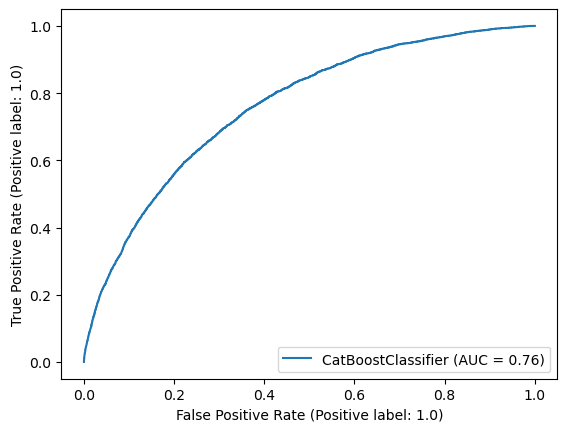

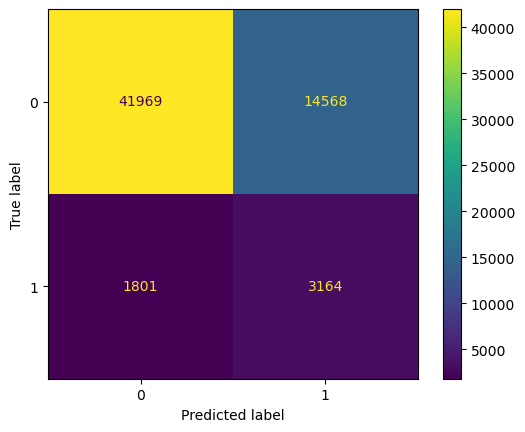

In [92]:
model = CatBoostClassifier(class_weights = [1, 10])
params = {
    'depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'random_strength': [0.1, 0.5, 1]
}
create_model_grid(model, 'CatBoost', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4f'> XGBoost

max_depth: La profondeur maximale de chaque arbre de décision. Une valeur plus élevée peut conduire à un modèle plus complexe, mais cela peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bytree: La proportion de caractéristiques utilisées pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

gamma: Le paramètre de régularisation qui contrôle la complexité des arbres. Une valeur plus élevée favorise une réduction plus importante des nœuds de l'arbre, ce qui peut prévenir le surajustement.

reg_alpha et reg_lambda: Les termes de régularisation L1 et L2 qui pénalisent respectivement les valeurs absolues des poids et les carrés des poids. Ils peuvent être utilisés pour contrôler la régularisation du modèle.

min_child_weight: Le poids minimum nécessaire pour créer un nouvel arbre enfant lors de la construction de l'arbre. Une valeur plus élevée peut conduire à un modèle plus conservateur avec moins de divisions.

Run - XGBoost_avec_smote is logged to Experiment - scoring_P7
Durée : 971.1824402809143 s


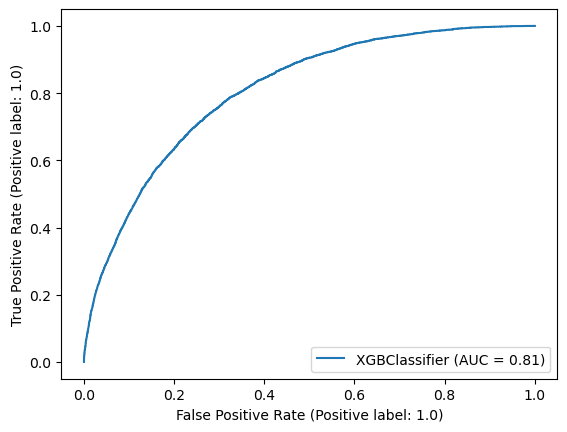

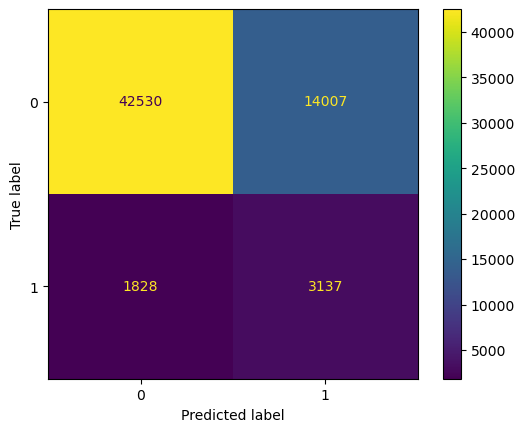

In [93]:
model = XGBClassifier()
params = {
    'scale_pos_weight' : [10],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}
create_model_grid(model, 'XGBoost_avec_smote', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4g'> LightGBM

max_depth: La profondeur maximale de chaque arbre. Une valeur plus élevée peut rendre le modèle plus complexe, mais peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bytree: La proportion de caractéristiques utilisées pour chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

reg_alpha et reg_lambda: Les termes de régularisation L1 et L2 qui pénalisent les poids des nœuds de l'arbre. Des valeurs plus élevées favorisent une réduction plus importante des poids, ce qui peut prévenir le surajustement.

min_child_samples: Le nombre minimal d'échantillons requis pour créer un nouveau nœud dans l'arbre. Une valeur plus élevée peut aider à prévenir le surajustement en rendant la construction de l'arbre plus conservatrice.

num_leaves: Le nombre maximal de feuilles dans chaque arbre. Une valeur plus élevée permet à l'arbre d'être plus complexe, mais cela peut également augmenter le risque de surajustement.

Run - LightGBM_avec_smote is logged to Experiment - scoring_P7
Durée : 88.41122007369995 s


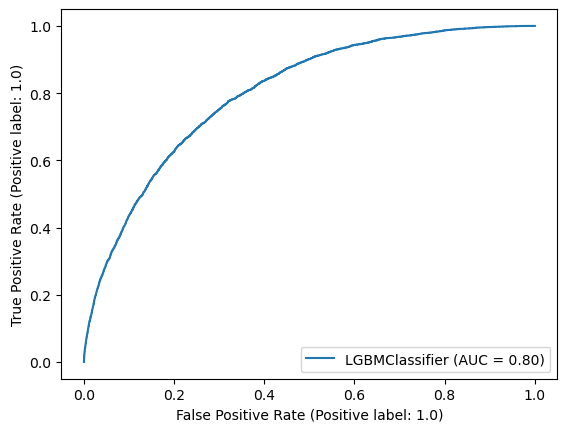

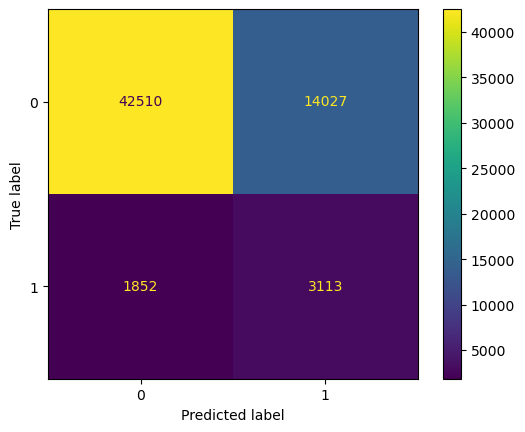

In [94]:
model = LGBMClassifier(class_weight = class_weights)
params = {
    'max_depth': [3, 6, -1],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_child_samples': [20, 50, 100],
    'num_leaves': [31, 63, 127]
}
create_model_grid(model, 'LightGBM_avec_smote', params, X_sample_imputed, y_sample, X_test_imputed)

### Fine tuning

In [95]:
def create_model_gridsearch(model, run_name, params, X_sample, y_sample, X_test):
    time_0 = time.time()
    
    # oversampling
    #oversample = SMOTE()
    #X_sample, y_sample = oversample.fit_resample(X_sample, y_sample)
    
    # GridSearch
    grid = GridSearchCV(model, param_grid = params, scoring = scorer, cv = 5)
    grid.fit(X_sample, y_sample)
    
    # Scores sur le jeu d'entraînement
    grid_params = grid.param_grid
    score_train(model, grid, grid_params, run_name, 'scoring_P7')
    
    # Scores du meilleur estimateur
    best_params = grid.best_params_
    estimator = grid.best_estimator_
    y_pred = seuil(estimator, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(estimator, X_sample, y_sample, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    
    create_experiment('scoring_P7', run_name, run_metrics, estimator, name_conf_mat, name_curve, best_params)
    
    duration = time.time() - time_0
    print(f'Durée : {duration} s')

Run - XGBoost_sans_smote is logged to Experiment - scoring_P7
Durée : 2814.738162279129 s


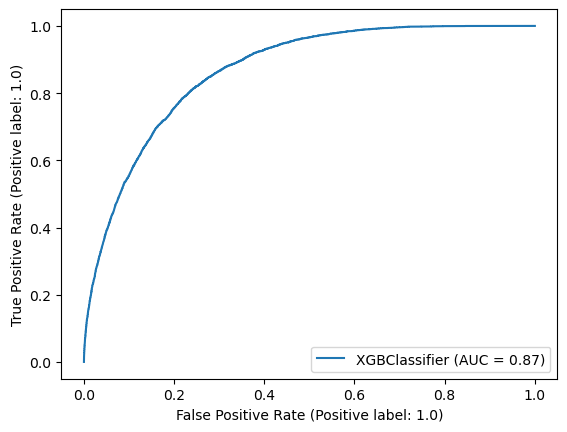

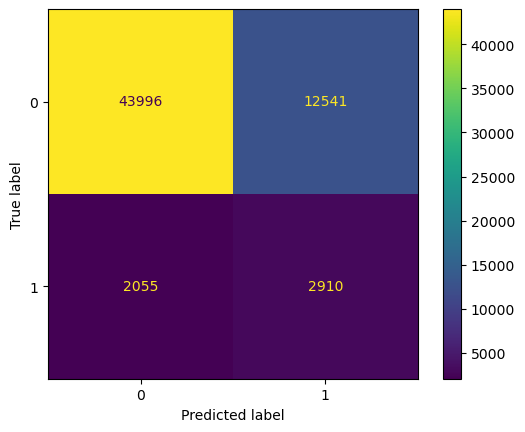

In [96]:
model = XGBClassifier()
params = {
    'scale_pos_weight' : [10],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'n_estimators': [150, 200, 250],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0.05, 0.1],
    'reg_alpha': [0],
    'reg_lambda': [0.15, 0.2],
    'min_child_weight': [3, 5]
}
create_model_gridsearch(model, 'XGBoost_sans_smote', params, X_sample, y_sample, X_test)

### <a name='4h'> Modèle retenu

Run - XGBClassifier_sans_smote is logged to Experiment - scoring_P7


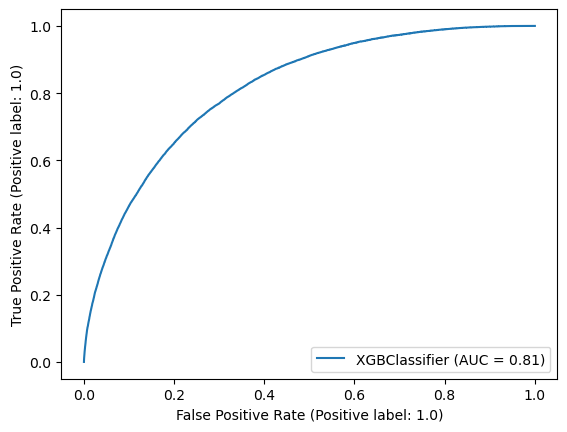

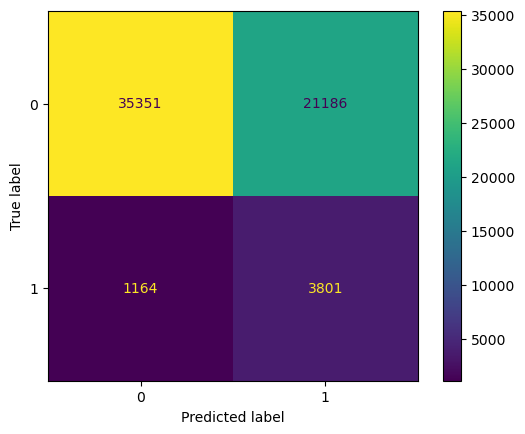

In [96]:
beta = 3
scorer = make_scorer(fbeta_score, beta = beta)
seuil_proba = 0.6

params = {
    'scale_pos_weight':10,
    'max_depth' : 5,
    'learning_rate' : 0.1,
    'n_estimators' : 200,
    'subsample' : 1.0,
    'colsample_bytree' : 1.0,
    'gamma' : 0.1,
    'reg_alpha' : 0,
    'reg_lambda' : 0.15,
    'min_child_weight' : 5
}

model = XGBClassifier(**params)

create_model(model, 'XGBClassifier_sans_smote', X_train, y_train, params)

Text(0.5, 1.0, 'Courbe ROC')

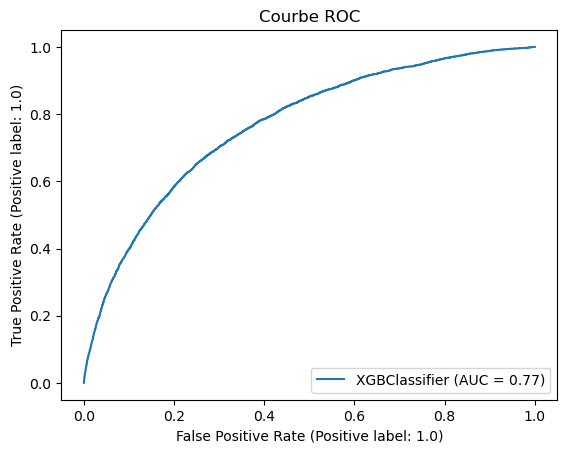

In [92]:
create_roc_auc_plot(model, X_test, y_test, 'XGBClassifier_sur_test')
plt.title('Courbe ROC')

Text(0.5, 1.0, 'Matrice de confusion')

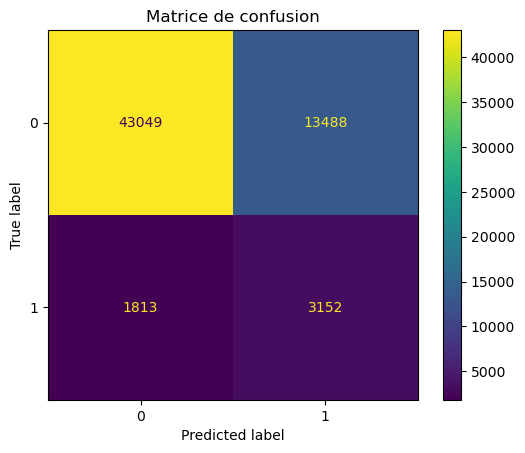

In [91]:
y_pred = model.predict(X_test)
create_confusion_matrix_plot(y_test, y_pred, 'XGBClassifier_sur_test')
plt.title('Matrice de confusion')

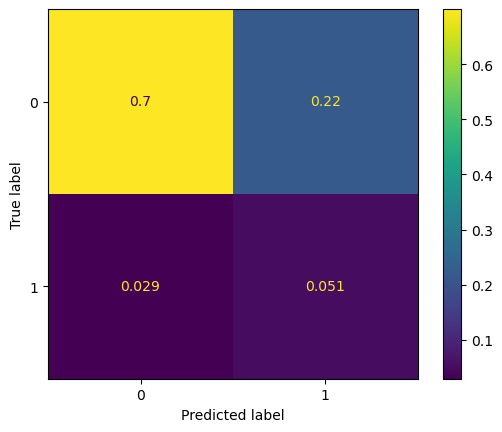

In [90]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'all', include_values = True)

## <a name='5'> 5) Feature importance

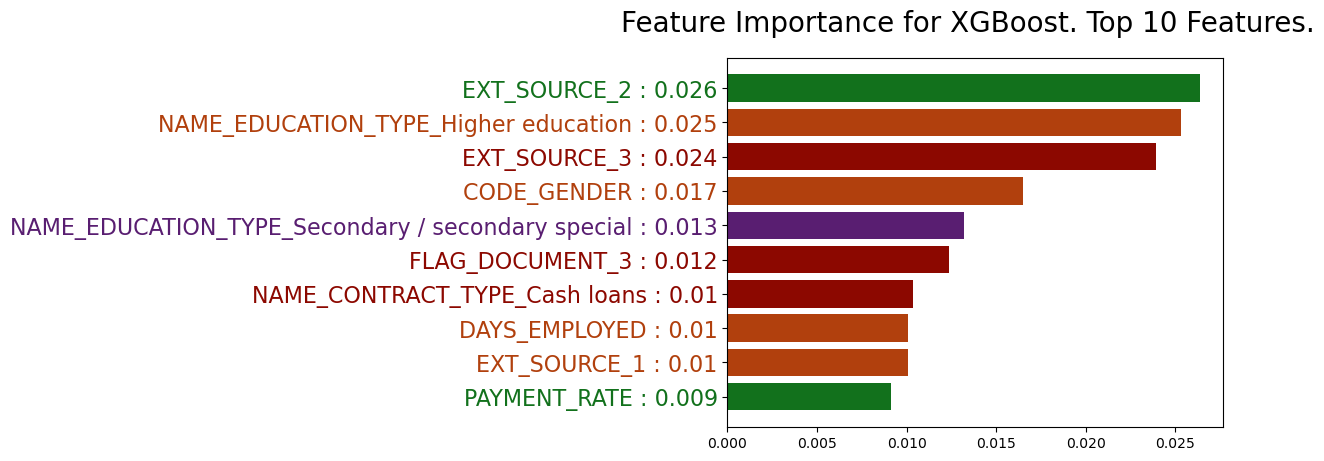

In [87]:
importance = model.feature_importances_
noms_col = X_train.columns

indices = np.argsort(importance)
indices = indices[-10:]

color_list =  sns.color_palette("dark", len(noms_col)) 

plt.barh(range(len(indices)), importance[indices], color= [color_list[indices[i]] for i in range(10)],
         align='center')
  
plt.yticks(range(len(indices)), [(noms_col[j] + ' : ' + str(round(importance[j],3))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for XGBoost. Top " + str(10) + " Features.", fontsize=20, fontweight="normal")
plt.show()

In [90]:
shap.initjs()

In [89]:
explainer = shap.TreeExplainer(model)

In [132]:
shap_values = explainer(X_test)

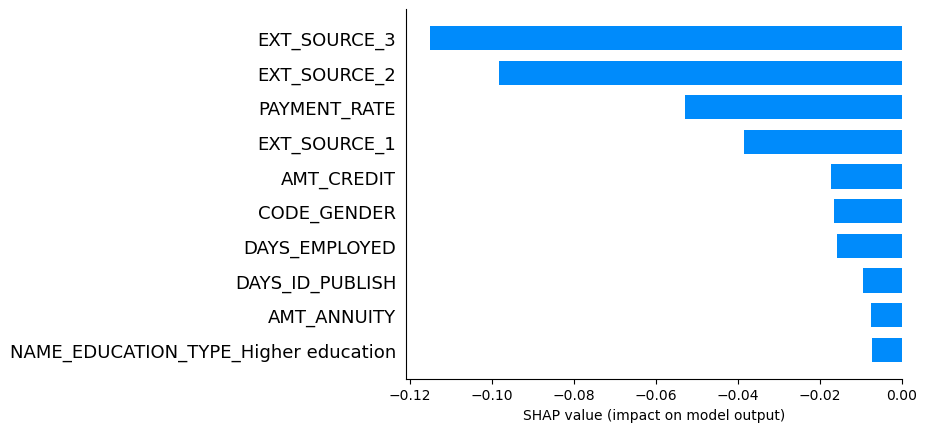

In [130]:
shap.bar_plot(sv,
              feature_names=X_test.columns,
              max_display=10)

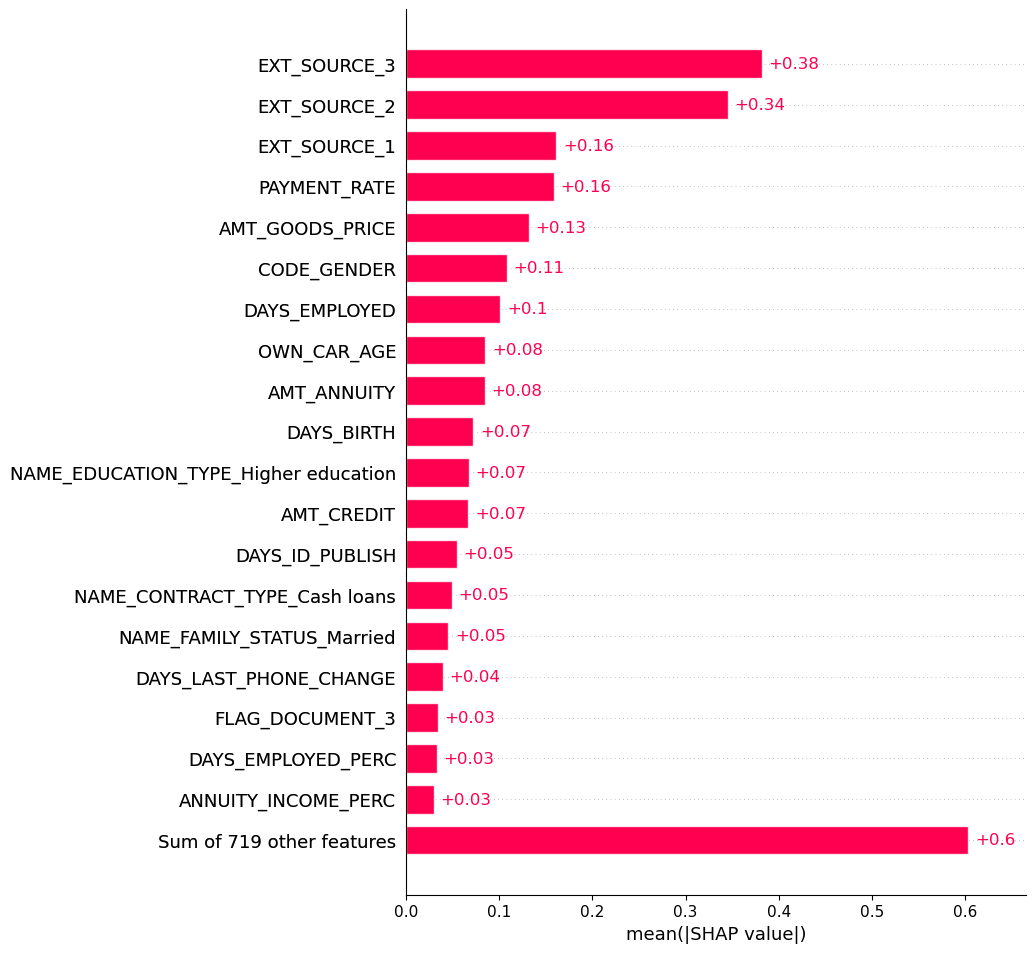

In [106]:
shap.plots.bar(shap_values, max_display = 20)

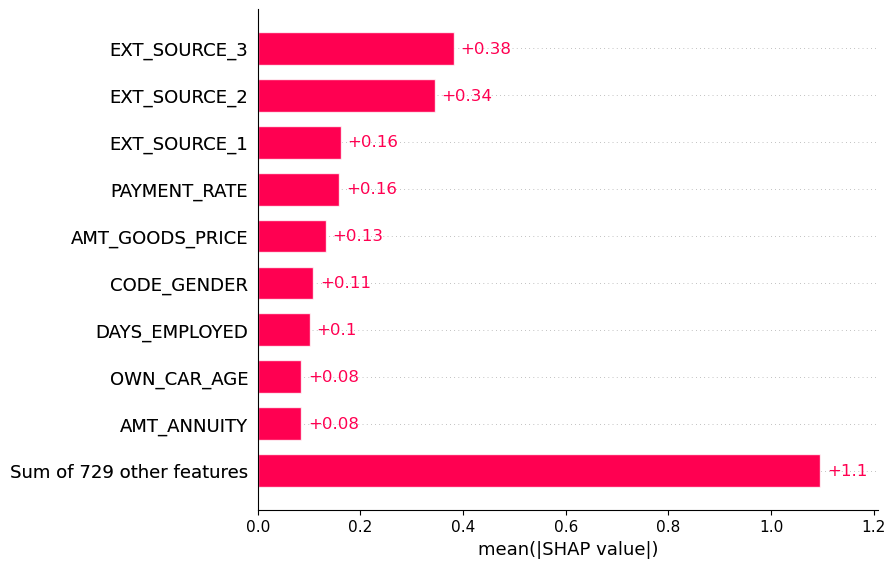

In [118]:
index = 4
shap.plots.bar(shap_values, max_display = 10)

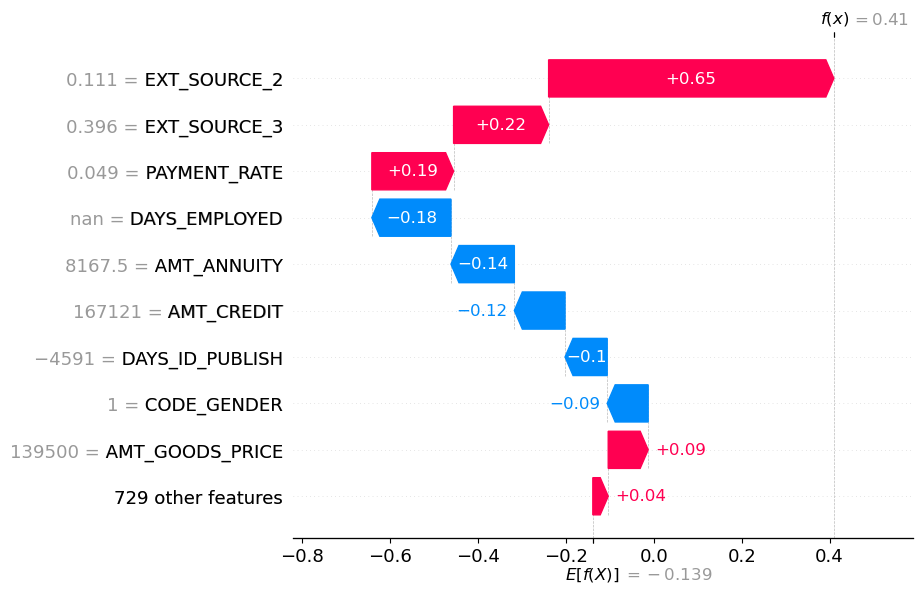

In [104]:
shap.plots.waterfall(shap_values[index])

##  <a name='6'> 6) Sauvegardes

In [102]:
# Sauvegarde du modèle retenu
dump(model, 'best_model.joblib')

['best_model.joblib']

In [130]:
# Sauvegarde du data test
X_test.reset_index(inplace=True, drop = True)
X_test.to_csv('donnees_test.csv',index = False)

In [149]:
# Sauvegarde du data train
X_train['TARGET'] = y_train
X_train.reset_index(inplace= True, drop = True)
X_train.to_csv('donnees_train.csv', index = False)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [151]:
# Sauvegarde d'un échantillon du data_train
X_sample['TARGET'] = y_sample
X_sample.reset_index(inplace= True, drop = True)
X_sample.to_csv('donnees_train_sample.csv', index = False)

In [88]:
# Sauvegarde d'un jeu de 10 données test pour travailler sur le dashboard
X_test_essai = X_test.sample(n = 100).reset_index(drop=True)
X_test_essai.to_csv('donnees_test_essai.csv', index = False)

In [85]:
# Sauvegarde d'un jeu de 10 données train pour travailler sur le dashboard
X_train['TARGET'] = y_train
X_train_essai = X_train.sample(n = 100).reset_index(drop = True)
X_train_essai.to_csv('donnees_train_essai.csv', index = False)

C:\Users\matth\AppData\Local\Temp\ipykernel_11060\676737131.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



## <a name='7'> Data drift

In [86]:
reference = app_train[:5000]
reference = reference.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
current = app_test[:5000]

In [87]:
report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference, current_data=current)
report

In [88]:
report.save_html('data_drift.html')